In [22]:
#check the proteomics data in AMP_PD
!ls /data/CARD/PD/AMP-PD/release2.5_preview/targeted

CSF_Cardio_Certificate_of_Analysis.pdf
CSF_INF_Certificate_of_Analysis.pdf
CSF_NEU_Certificate_of_Analysis.pdf
CSF_ONC_Certificate_of_Analysis.pdf
ColumnHeaderGlossary.csv
Plasma_CARDIO_Certificate_of_Analysis.pdf
Plasma_INF_Certificate_of_Analysis.pdf
Plasma_NEURO_Certificate_of_Analysis.pdf
Plasma_ONC_Certificate_of_Analysis.pdf
PreviewRelease_Cardiometabolic_CSF_NPX.csv
PreviewRelease_Cardiometabolic_Plasma_NPX.csv
PreviewRelease_Inflammation_CSF_NPX.csv
PreviewRelease_Inflammation_Plasma_NPX.csv
PreviewRelease_Neurology_CSF_NPX.csv
PreviewRelease_Neurology_Plasma_NPX.csv
PreviewRelease_Oncology_CSF_NPX.csv
PreviewRelease_Oncology_Plasma_NPX.csv
README.txt


In [118]:
#download data 
#! cp -R /data/CARD/PD/AMP-PD/release2.5_preview/targeted/PreviewRelease_*.csv /{datadir}/
#! cp -R /data/CARD/PD/AMP-PD/release2.5_preview/targeted/ColumnHeaderGlossary.csv /{datadir}/
###NPX is normalized protein expression (log2 scale)

In [1]:
# set paths
#!mkdir data_folder
basedir = '/data/songy4/proteomics_196'
datadir = f'{basedir}/data_folder'
twasdir = f'/data/songy4/twas/data_folder'

#upload some libraries
import os
import pandas.testing as tm
import h5py
import numpy as np
import pandas as pd
import math
import sys
import subprocess
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from patsy.builtins import *
import statistics
import umap.umap_ as umap
from joblib import dump, load
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.decomposition import PCA

! pip install --upgrade tables
import tables

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#read a file and check the data
CSF_Cardio = pd.read_csv(f"/data/CARD/PD/AMP-PD/release2.5_preview/targeted/PreviewRelease_Cardiometabolic_CSF_NPX.csv", engine='c', index_col=False)
print('shape of PPMI_Project_196_CSF_Cardio_Counts data:', CSF_Cardio.shape)
print(CSF_Cardio.head())
print(CSF_Cardio.describe())
print('Column names: ', CSF_Cardio.columns)

shape of PPMI_Project_196_CSF_Cardio_Counts data: (274167, 11)
  participant_id                       sample_id  visit_month UniProt  \
0  PD-PDTY429DAG  PD-PDTY429DAG-SVM18T1-CSF-PPEA           18  O00584   
1  PD-PDTY429DAG  PD-PDTY429DAG-SVM18T1-CSF-PPEA           18  Q07108   
2  PD-PDTY429DAG  PD-PDTY429DAG-SVM18T1-CSF-PPEA           18  P35754   
3  PD-PDTY429DAG  PD-PDTY429DAG-SVM18T1-CSF-PPEA           18  Q9H5Y7   
4  PD-PDTY429DAG  PD-PDTY429DAG-SVM18T1-CSF-PPEA           18  P31431   

     Assay  MissingFreq            Panel                       PlateID  \
0  RNASET2       0.0000  Cardiometabolic  20201991_SS200115_CARDIO_INF   
1     CD69       0.0000  Cardiometabolic  20201991_SS200115_CARDIO_INF   
2     GLRX       0.0000  Cardiometabolic  20201991_SS200115_CARDIO_INF   
3  SLITRK6       0.0026  Cardiometabolic  20201991_SS200115_CARDIO_INF   
4     SDC4       0.0000  Cardiometabolic  20201991_SS200115_CARDIO_INF   

  QC_Warning     LOD     NPX  
0       PASS -4.6696  

In [3]:
#check unique values in each column
for i in CSF_Cardio.columns[0:14]:
    print('Number of unique value of ' + i + ':', CSF_Cardio[i].nunique())

#check nan numbers in each column 
print('null value in each column: \n', CSF_Cardio.isna().sum())

#check data type in all column
print('data types in each column: \n',CSF_Cardio.dtypes)

##print unique EVENT_ID and count
print('Unique value of visit_month :' , CSF_Cardio['visit_month'].unique())
print(CSF_Cardio.visit_month.value_counts())

#check unique participant number
print('Unique value of participant_id :' , CSF_Cardio.participant_id.unique())

Number of unique value of participant_id: 212
Number of unique value of sample_id: 743
Number of unique value of visit_month: 10
Number of unique value of UniProt: 369
Number of unique value of Assay: 369
Number of unique value of MissingFreq: 130
Number of unique value of Panel: 1
Number of unique value of PlateID: 9
Number of unique value of QC_Warning: 2
Number of unique value of LOD: 3281
Number of unique value of NPX: 107610
null value in each column: 
 participant_id    0
sample_id         0
visit_month       0
UniProt           0
Assay             0
MissingFreq       0
Panel             0
PlateID           0
QC_Warning        0
LOD               0
NPX               0
dtype: int64
data types in each column: 
 participant_id     object
sample_id          object
visit_month         int64
UniProt            object
Assay              object
MissingFreq       float64
Panel              object
PlateID            object
QC_Warning         object
LOD               float64
NPX            

In [4]:
#select baseline for event id
csf_cardio_baseline = CSF_Cardio.query("visit_month==0").reset_index(drop=True)
print('shape of PDBP_PPMI_Project_196_CSF_Cardio_Baseline:', csf_cardio_baseline.shape)
print(csf_cardio_baseline.head())
#count how many pass and warn in QC_WARNING	
print('Number of Pass/Fail in QC_WARNING: ', csf_cardio_baseline.QC_Warning.value_counts())
#details of csf_cardio_baseline
print("Number of unique participant number: " ,csf_cardio_baseline.participant_id.nunique())
print("Number of unique Uniprot number: " ,csf_cardio_baseline.UniProt.nunique())
print("Number of unique Assay number: " ,csf_cardio_baseline.Assay.nunique())

shape of PDBP_PPMI_Project_196_CSF_Cardio_Baseline: (68265, 11)
  participant_id                      sample_id  visit_month UniProt    Assay  \
0  PD-PDVX986CEU  PD-PDVX986CEU-BLM0T1-CSF-PPEA            0  O00584  RNASET2   
1  PD-PDVX986CEU  PD-PDVX986CEU-BLM0T1-CSF-PPEA            0  Q07108     CD69   
2  PD-PDVX986CEU  PD-PDVX986CEU-BLM0T1-CSF-PPEA            0  P35754     GLRX   
3  PD-PDVX986CEU  PD-PDVX986CEU-BLM0T1-CSF-PPEA            0  Q9H5Y7  SLITRK6   
4  PD-PDVX986CEU  PD-PDVX986CEU-BLM0T1-CSF-PPEA            0  P31431     SDC4   

   MissingFreq            Panel                       PlateID QC_Warning  \
0       0.0000  Cardiometabolic  20201991_SS200115_CARDIO_INF       PASS   
1       0.0000  Cardiometabolic  20201991_SS200115_CARDIO_INF       PASS   
2       0.0000  Cardiometabolic  20201991_SS200115_CARDIO_INF       PASS   
3       0.0026  Cardiometabolic  20201991_SS200115_CARDIO_INF       PASS   
4       0.0000  Cardiometabolic  20201991_SS200115_CARDIO_INF       P

Create Expression PCs, Check PC significant by Scree Plot/ PCA Plot, Check variances in each protein 

In [5]:
#drop columns not needed
csf_cardio_df = csf_cardio_baseline[['participant_id', 'Assay', 'NPX']].reset_index(drop=True)
#change dataframe into the format wanted by grouping by PATNO and ASSAY
csf_cardio_df = csf_cardio_df.groupby(['participant_id', 'Assay']).sum()
csf_cardio_df = csf_cardio_df['NPX'].unstack().reset_index().rename_axis(None, axis=1)

#change PATNO format
#csf_cardio_df['participant_id'] = csf_cardio_df['PATNO'].str.replace('MI','')
#rename PATNO to ID
csf_cardio_df.rename(columns={'participant_id':'ID'}, inplace=True)
csf_cardio_df

,ID,ACAN,ACE2,ACOX1,ACP5,ACTA2,ACY1,ADA2,ADAM15,ADAMTS13,...,VAMP5,VASN,VCAM1,VIM,VSIR,VSTM2L,VWF,WASF1,XG,ZBTB17
0,PD-PDAB411CTU,-0.9684,-2.6034,-0.2336,-1.3416,-0.2686,-2.9338,-1.6870,-0.4382,-6.1849,...,0.0066,-1.9421,-1.7906,0.1733,1.6514,-1.0659,-6.6061,0.1030,-2.2783,-1.5020
1,PD-PDAE940EZ5,-0.2638,-3.0993,0.0940,-0.7612,-0.5682,-3.2224,-1.0228,0.6516,-6.5064,...,-0.2545,-1.6420,-1.9001,0.4669,2.1536,-0.3293,-6.4604,0.4236,-1.1918,-1.3527
2,PD-PDBB001EMM,-0.2691,-2.5923,0.4753,-0.9073,0.6244,-3.2537,-1.7862,0.4610,-6.0543,...,-0.1122,-1.9197,-2.0484,-0.5570,1.8787,0.0461,-5.9034,1.1415,-1.7551,-1.5858
3,PD-PDBD207ERC,-0.2186,-2.2076,-0.2373,-0.9850,0.3743,-4.0296,-1.0531,0.1732,-6.2396,...,0.3691,-2.0344,-2.4130,0.3064,1.6581,0.1378,-6.5725,0.6745,-1.4837,-1.2290
4,PD-PDBE283ED7,-0.7482,-2.4608,0.4592,-1.1386,0.4938,-3.8192,-1.5379,-0.3345,-6.9813,...,0.4421,-1.8531,-2.0534,1.1578,1.8495,-0.5586,-7.0291,0.1558,-1.7894,-1.4379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,PP-4102,1.1264,-2.7481,-0.2411,-0.0713,1.0216,-2.4635,-0.0434,1.5155,-5.5541,...,0.1112,-0.4028,-0.5248,0.9539,3.5693,0.2925,-6.4852,1.1730,-0.3224,-2.1825
181,PP-4103,0.2941,-2.2767,-0.4200,-0.6003,1.0781,-2.8720,-0.9954,0.9925,-5.5212,...,0.3818,-1.0520,-1.2619,0.1651,1.9987,-0.0593,-5.9440,0.8566,-1.7250,-0.7252
182,PP-4110,1.8005,-2.3871,1.1255,-0.4712,2.2759,-2.1434,0.0948,1.2941,-6.0753,...,0.2781,-0.9324,-0.9172,0.2813,3.2130,-0.3990,-4.9195,1.1077,-1.2715,-1.4337
183,PP-4113,-0.7704,-2.5854,0.4027,-1.4986,-0.2299,-3.7683,-2.0751,-0.5750,-6.6026,...,-0.0151,-2.0962,-2.9165,0.0444,1.5053,-0.0731,-5.9333,0.5843,-1.7107,-1.0539


In [6]:
#read twas pheno data
pheno_df = pd.read_csv(f"/data/songy4/twas/data_folder/baseline_VST_proteincoding_omics_OG_PPMI_AND_PDBP_ALLTRANSCRIPTS_10PCs_loadings.csv", engine='c')
pheno_df.drop(pheno_df.iloc[:,2:12], axis=1, inplace=True)

#get csf_cardio_df ID as list
pheno_list = list(csf_cardio_df.ID)
#drop rows if ID is not in the list
pheno = (pheno_df[pheno_df['ID'].isin(pheno_list)]).reset_index(drop=True)

#get csf_cardio_df ID as list
id_list = list(pheno.ID)
#drop rows if ID is not in the list
csf_cardio = (csf_cardio_df[csf_cardio_df['ID'].isin(id_list)]).reset_index(drop=True)

Make PCs from expression data

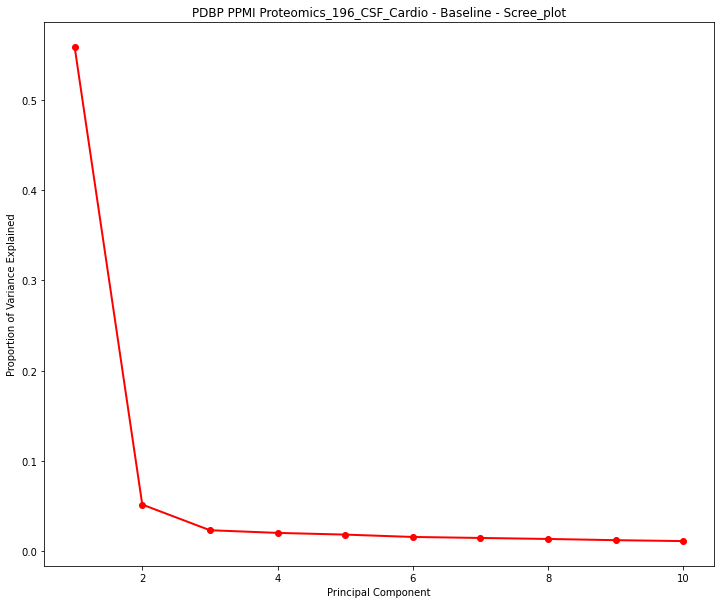

In [8]:
# combine case and control
#cardio_combined = pd.concat([case, control], axis=0)
#drop FID and IID
X = csf_cardio.drop(columns=['ID'])

# Run PCA
n_components = 10
pca = PCA(n_components=n_components, svd_solver='randomized')
X_pca = pca.fit(X)

# Lets see what % of the variance in the data each component explains.
PC_values = np.arange(X_pca.n_components_) + 1
plt.plot(PC_values, X_pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
figure = plt.gcf()
figure.set_size_inches(12, 10)
plt.title("PDBP PPMI Proteomics_196_CSF_Cardio - Baseline - Scree_plot") 
plt.savefig(r'./data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_Scree_plot.png', dpi=300)
plt.show()

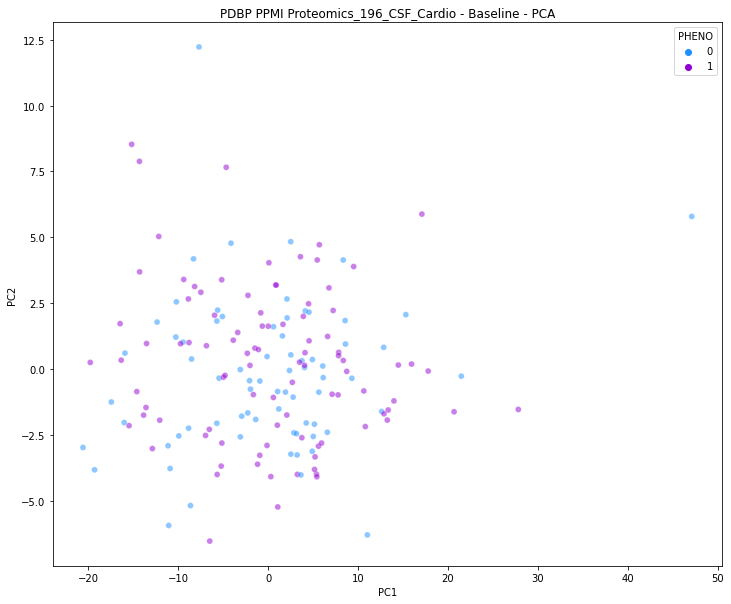

,ID,PHENO,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,PD-PDAB411CTU,0,4.047538,0.056519,1.518726,0.595924,-1.747743,-0.197117,-1.344168,-0.125827,0.385564,-0.775254
1,PD-PDAE940EZ5,0,3.224947,-3.265350,6.529409,1.816563,0.656536,0.346635,0.279689,0.586670,1.351985,0.557217
2,PD-PDBB001EMM,0,2.862528,-2.425020,-0.935912,-0.051684,0.877002,-0.240787,0.456325,0.664591,-0.688242,-1.453866
3,PD-PDBD207ERC,0,6.123784,-0.328313,0.602490,-2.423884,1.921248,0.498434,1.389629,1.012399,-0.363779,-0.630033
4,PD-PDBE283ED7,1,5.376369,-3.993669,-2.037212,-0.955598,-0.474138,-1.696572,-1.882345,-0.357585,-0.097750,-1.020687


In [9]:
# Now lets get the loadings themselves
X_loadings = pca.fit_transform(X)
X_loadings_df = pd.DataFrame(data = X_loadings, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6','PC7', 'PC8', 'PC9', 'PC10'])

# Make the data to plot
plotting_df = pd.concat([pheno, X_loadings_df], axis = 1)

# Pretty plot time!
plt.figure()
sns.scatterplot(data=plotting_df, x='PC1', y='PC2', hue='PHENO', alpha=0.5, palette=['dodgerblue','darkviolet'])
figure = plt.gcf()
figure.set_size_inches(12, 10)
plt.title("PDBP PPMI Proteomics_196_CSF_Cardio - Baseline - PCA") 
plt.savefig(r'./data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_PC_plot.png', dpi=300)
plt.show()
plotting_df.head()

In [14]:
# Save the pheno, dataframe and loadings
pheno.to_csv(r'./data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_pheno.csv', index=False)
csf_cardio.to_csv(r'./data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_before_munge.csv', index=False)
plotting_df.to_csv(r'./data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_10PCs_loadings.csv', index=False)

Compare how many each step drops data and make decision
## Warn from QC_Warning was dropped
## LOD bigger than NPX were not dropped since there were too many
## Missing Freq bigger than 95% was dropped

In [15]:
#csf_cardio.dtypes
#csf_cardio[csf_cardio.columns[1:370]]

#check variation for each protein
stats=pd.DataFrame()
stats["Mean"] = csf_cardio.mean()
stats["Std_dev"] = csf_cardio.std()
stats["Variance"] = csf_cardio.var()
stats["CV"] = (stats["Std_dev"]/stats["Mean"])
stats.T

,ACAN,ACE2,ACOX1,ACP5,ACTA2,ACY1,ADA2,ADAM15,ADAMTS13,ADAMTS16,...,VAMP5,VASN,VCAM1,VIM,VSIR,VSTM2L,VWF,WASF1,XG,ZBTB17
Mean,-0.273877,-2.475714,-0.067516,-0.931388,0.558656,-3.162999,-0.984821,0.385822,-6.243838,-1.010887,...,0.128218,-1.634616,-1.580357,0.371369,2.060735,-0.351103,-6.315454,0.610815,-1.195017,-1.333938
Std_dev,0.837075,0.234312,0.505039,0.638107,0.691787,0.575273,0.591067,0.691398,0.588285,0.284786,...,0.300339,0.595956,0.701973,0.973625,0.650727,0.387279,0.555458,0.347244,0.672500,0.258879
Variance,0.700695,0.054902,0.255065,0.407180,0.478569,0.330939,0.349360,0.478032,0.346079,0.081103,...,0.090204,0.355164,0.492766,0.947946,0.423446,0.149985,0.308534,0.120578,0.452256,0.067018
CV,-3.056395,-0.094644,-7.480340,-0.685114,1.238305,-0.181876,-0.600177,1.792016,-0.094218,-0.281719,...,2.342410,-0.364585,-0.444186,2.621720,0.315774,-1.103034,-0.087952,0.568492,-0.562753,-0.194071


In [16]:
#check min and max of variance 
print('Max value:' , stats.max())
print('Min value:' , stats.min())
#print('Min value:' , stats.min(axis=1))

#check how many proteins are <1 and >1
print('Value greater than 1:' ,stats.gt(1).sum())
print('Value less than 1:' ,stats.lt(1).sum())

Max value: Mean           6.943990
Std_dev        1.891316
Variance       3.577074
CV          4489.767338
dtype: float64
Min value: Mean        -7.420405
Std_dev      0.120483
Variance     0.014516
CV         -75.633572
dtype: float64
Value greater than 1: Mean        104
Std_dev      18
Variance     18
CV           38
dtype: int64
Value less than 1: Mean        265
Std_dev     351
Variance    351
CV          331
dtype: int64


In [17]:
#check cardio panel
cardio_panel = csf_cardio.columns[1:370].tolist()
#make trans list as a dataframe
panel = pd.DataFrame(cardio_panel, columns=["Cardio_ID"])
# Save the pheno, dataframe and loadings
panel.to_csv(r'./data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_panel.txt', index=False, header=None)

Prepare expression dataset

In [18]:
#check the unique values of LOD and MISSINGFREQ to see if any needs to be dropped
print('Unique value of MissingFreq:' , csf_cardio_baseline['MissingFreq'].unique())
print('Max value of LOD:' , csf_cardio_baseline['LOD'].max())
print('Min value of LOD:' , csf_cardio_baseline['LOD'].min())

Unique value of MissingFreq: [0.     0.0026 0.038  0.2461 0.9228 0.0301 0.0157 0.8259 0.8312 0.0013
 0.0039 0.6479 0.3416 0.0196 0.6832 0.0668 0.0079 0.0602 0.644  0.9856
 0.0955 0.0052 0.6073 0.2147 0.6139 0.0746 0.2094 0.0105 0.0092 0.017
 0.9725 0.4791 0.0694 0.0183 0.1675 0.195  0.7657 0.5327 0.0929 0.784
 0.8809 0.8835 0.8652 1.     0.9751 0.7971 0.7147 0.9175 0.6754 0.0223
 0.9673 0.7788 0.9411 0.6335 0.7762 0.0628 0.9188 0.8298 0.2016 0.9568
 0.6414 0.9045 0.6296 0.4908 0.9267 0.0825 0.0576 0.8102 0.0982 0.1283
 0.9699 0.8285 0.6387 0.911  0.0563 0.1099 0.0524 0.5812 0.5654 0.7893
 0.9843 0.6859 0.0707 0.801  0.5969 0.0065 0.9005 0.538  0.3521 0.3364
 0.0353 0.123  0.1008 0.1924 0.3194 0.0458 0.1728 0.106  0.284  0.5497
 0.2958 0.1492 0.4542 0.089  0.3547 0.6322 0.7683 0.2788 0.9777 0.8665
 0.4097 0.3063 0.856  0.7277 0.0772 0.9058 0.9542 0.0864 0.5838 0.428
 0.6086 0.1165 0.3848 0.034  0.0144 0.6283 0.7958 0.7997 0.8927 0.4058]
Max value of LOD: 3.6094
Min value of LOD: -10.379

In [19]:
#check how many unique LOD are in each ASSAY
#csf_cardio_baseline.groupby('ASSAY')['LOD'].apply(lambda x: x.unique().tolist())
lod_num = csf_cardio_baseline.groupby('Assay')['LOD'].apply(lambda x: x.nunique())
print(lod_num.head())

#check if all ASSAY has 9 different LOD
less_lod = csf_cardio_baseline.groupby('Assay').LOD.nunique() < 9
print('Protein name that has less than 9 unique LOD: ' ,less_lod[less_lod].index.tolist())

#check how many unique LOD PTPRF has
print('Number of unique LOD in the protein: ' ,csf_cardio_baseline[csf_cardio_baseline.Assay == 'PTPRF'].LOD.nunique())

Assay
ACAN     9
ACE2     9
ACOX1    9
ACP5     9
ACTA2    9
Name: LOD, dtype: int64
Protein name that has less than 9 unique LOD:  ['PTPRF']
Number of unique LOD in the protein:  8


In [20]:
#whole row numbers
whole = csf_cardio_baseline['QC_Warning'].count()

#check the number of rows got dropped
print('Number of rows contained WARN in QC_Warning: ', csf_cardio_baseline[csf_cardio_baseline.QC_Warning == 'WARN']['QC_Warning'].count())

#drop rows with WARN in QC_WARNING
csf_cardio_bl_pass = csf_cardio_baseline[csf_cardio_baseline['QC_Warning'].str.contains('PASS')].reset_index(drop=True)
#count rows qc pass
qc = csf_cardio_bl_pass['QC_Warning'].count()

#check the number of rows got dropped
print('Number of rows where NPX is below LOD: ', csf_cardio_bl_pass[(csf_cardio_bl_pass['LOD'] > csf_cardio_bl_pass['NPX'])]['LOD'].count())
#drop rows that NPX is below LOD
csf_cardio_bl_pass_npx = csf_cardio_bl_pass[(csf_cardio_bl_pass['LOD'] <= csf_cardio_bl_pass['NPX'])].reset_index(drop=True)

#count rows LOD not bigger than NPX
lod = csf_cardio_bl_pass_npx['LOD'].count()

#check MISSINGFREQ exclusion criteria (max is 1 and min is 0 for MISSINGFREQ)
mf95 = csf_cardio_bl_pass_npx[csf_cardio_bl_pass_npx.MissingFreq <= 0.95]['MissingFreq'].count()
mf98 = csf_cardio_bl_pass_npx[csf_cardio_bl_pass_npx.MissingFreq <= 0.98]['MissingFreq'].count()
mf99 =  csf_cardio_bl_pass_npx[csf_cardio_bl_pass_npx.MissingFreq <= 0.99]['MissingFreq'].count()
print('Number of rows contained MissingFreq bigger than 0.95: ', csf_cardio_bl_pass_npx[csf_cardio_bl_pass_npx.MissingFreq > 0.95]['MissingFreq'].count())
print('Number of rows contained MissingFreq bigger than 0.98: ', csf_cardio_bl_pass_npx[csf_cardio_bl_pass_npx.MissingFreq > 0.98]['MissingFreq'].count())
print('Number of rows contained MissingFreq bigger than 0.99: ', csf_cardio_bl_pass_npx[csf_cardio_bl_pass_npx.MissingFreq > 0.99]['MissingFreq'].count())

#drop rows with MISSINGFREQ bigger than .95
csf_cardio_bl_pass_npx_fq = csf_cardio_bl_pass_npx[csf_cardio_bl_pass_npx['MissingFreq'] <= 0.95].reset_index(drop=True)
print("Shape of csf_cardio_bl_pass_npx_fq: ",csf_cardio_bl_pass_npx_fq.shape)                                       
csf_cardio_bl_pass_npx_fq.head()                            


Number of rows contained WARN in QC_Warning:  4892
Number of rows where NPX is below LOD:  11417
Number of rows contained MissingFreq bigger than 0.95:  44
Number of rows contained MissingFreq bigger than 0.98:  3
Number of rows contained MissingFreq bigger than 0.99:  0
Shape of csf_cardio_bl_pass_npx_fq:  (51912, 11)


,participant_id,sample_id,visit_month,UniProt,Assay,MissingFreq,Panel,PlateID,QC_Warning,LOD,NPX
0,PD-PDVX986CEU,PD-PDVX986CEU-BLM0T1-CSF-PPEA,0,O00584,RNASET2,0.0000,Cardiometabolic,20201991_SS200115_CARDIO_INF,PASS,-4.6696,4.3923
1,PD-PDVX986CEU,PD-PDVX986CEU-BLM0T1-CSF-PPEA,0,Q07108,CD69,0.0000,Cardiometabolic,20201991_SS200115_CARDIO_INF,PASS,-4.9797,1.4989
2,PD-PDVX986CEU,PD-PDVX986CEU-BLM0T1-CSF-PPEA,0,P35754,GLRX,0.0000,Cardiometabolic,20201991_SS200115_CARDIO_INF,PASS,-2.5716,1.8638
3,PD-PDVX986CEU,PD-PDVX986CEU-BLM0T1-CSF-PPEA,0,Q9H5Y7,SLITRK6,0.0026,Cardiometabolic,20201991_SS200115_CARDIO_INF,PASS,-1.6953,2.3445
4,PD-PDVX986CEU,PD-PDVX986CEU-BLM0T1-CSF-PPEA,0,P31431,SDC4,0.0000,Cardiometabolic,20201991_SS200115_CARDIO_INF,PASS,-5.4027,-0.0199


In [21]:
#get the rows LOD is bigger than NPX
csf_cardio_bl_pass_lod_npx = csf_cardio_bl_pass[(csf_cardio_bl_pass['LOD'] > csf_cardio_bl_pass['NPX'])].reset_index(drop=True)

#drop columns not needed
csf_cardio_lod_df = csf_cardio_bl_pass_lod_npx[['participant_id', 'Assay', 'NPX']].reset_index(drop=True)
#change dataframe into the format wanted by grouping by PATNO and ASSAY
csf_cardio_lod_df = csf_cardio_lod_df.groupby(['participant_id', 'Assay']).sum()
csf_cardio_lod_df = csf_cardio_lod_df['NPX'].unstack().reset_index().rename_axis(None, axis=1)

#change PATNO format
#csf_cardio_df['participant_id'] = csf_cardio_df['participant_id'].str.replace('MI','')
#rename PATNO to ID
csf_cardio_lod_df.rename(columns={'participant_id':'ID'}, inplace=True)

#drop rows if ID is not in the list
csf_cardio_lod_df = (csf_cardio_lod_df[csf_cardio_lod_df['ID'].isin(id_list)]).reset_index(drop=True)
# Save the csf_cardio_df
#csf_cardio_df.to_csv(r'./data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_ProteinCoding.csv', index=False)

csf_cardio_lod_df

,ID,ACE2,ACOX1,ACTA2,ACY1,ADAMTS13,ADAMTS16,ADGRG2,ADH4,AGXT,...,TSPAN1,TYMP,UMOD,USP8,VAMP5,VIM,VSTM2L,WASF1,XG,ZBTB17
0,PD-PDAB411CTU,NaN,-0.2336,NaN,NaN,NaN,NaN,NaN,NaN,-3.0082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PD-PDAE940EZ5,-3.0993,0.0940,NaN,NaN,NaN,NaN,NaN,-5.1255,-2.8917,...,-1.0352,NaN,NaN,NaN,-0.2545,0.4669,NaN,0.4236,NaN,-1.3527
2,PD-PDBB001EMM,-2.5923,0.4753,NaN,NaN,NaN,NaN,NaN,-4.6164,-2.9078,...,-0.3847,NaN,NaN,NaN,-0.1122,-0.5570,NaN,NaN,NaN,-1.5858
3,PD-PDBD207ERC,NaN,-0.2373,NaN,NaN,NaN,-0.8962,NaN,-5.0023,-2.8736,...,-0.7636,NaN,NaN,NaN,NaN,0.3064,0.1378,0.6745,NaN,-1.2290
4,PD-PDBE283ED7,-2.4608,NaN,NaN,NaN,NaN,NaN,NaN,-5.3379,-3.1893,...,-0.6315,NaN,-6.0843,NaN,NaN,1.1578,-0.5586,0.1558,NaN,-1.4379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,PP-4101,-2.9955,NaN,-0.9182,NaN,-7.1215,-1.6110,NaN,-5.2481,NaN,...,-0.7090,NaN,NaN,-4.5273,-0.6496,1.0572,-0.7458,NaN,NaN,-1.5569
163,PP-4102,-2.7481,-0.2411,NaN,NaN,NaN,NaN,NaN,-4.7711,-2.9109,...,-0.9393,NaN,NaN,NaN,NaN,0.9539,NaN,NaN,NaN,-2.1825
164,PP-4103,-2.2767,-0.4200,NaN,NaN,NaN,NaN,NaN,-4.5885,-3.0717,...,-0.5344,NaN,NaN,NaN,NaN,0.1651,NaN,0.8566,NaN,NaN
165,PP-4110,-2.3871,NaN,NaN,NaN,NaN,NaN,NaN,-4.4471,-2.4516,...,-0.6777,NaN,NaN,NaN,0.2781,0.2813,-0.3990,NaN,NaN,-1.4337


Max value: Count    154
dtype: int64
Min value: Count    1
dtype: int64
          Count
ACE2        145
ACOX1       140
ACTA2         9
ACY1          1
ADAMTS13     16


<AxesSubplot:>

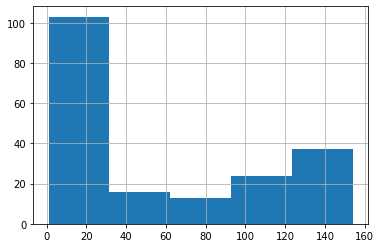

In [22]:
#count non null values per each protein (column)
lod_big = pd.DataFrame(csf_cardio_lod_df.count(), columns = ['Count'])
lod_big = lod_big.iloc[1:]
print('Max value:' ,lod_big.max())
print('Min value:' ,lod_big.min())
print(lod_big.head())

#plot a histogram with 5 bins
lod_big.Count.hist(bins=5)
#plot = lod_big.plot(kind="hist")
#plot.set_xlabel("X")
#plot.set_ylabel("Y")

Max value: ID       PP-4121
Count        174
dtype: object
Min value: ID       PD-PDAB411CTU
Count               13
dtype: object
              ID  Count
0  PD-PDAB411CTU     28
1  PD-PDAE940EZ5     72
2  PD-PDBB001EMM     71
3  PD-PDBD207ERC     67
4  PD-PDBE283ED7     73


<AxesSubplot:>

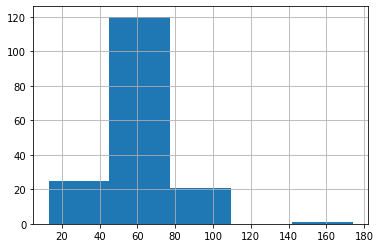

In [23]:
#count non null values per each row (samples)
lod_big_row = pd.DataFrame(csf_cardio_lod_df[csf_cardio_lod_df.columns[1:194]].count(axis=1), columns = ['Count'])
lod_big_row.insert(0, 'ID', csf_cardio_lod_df['ID'])
print('Max value:' ,lod_big_row.max())
print('Min value:' ,lod_big_row.min())
print(lod_big_row.head())

#plot a histogram with 5 bins
lod_big_row.Count.hist(bins=5)
#plot = lod_big.plot(kind="hist")
#plot.set_xlabel("X")
#plot.set_ylabel("Y")

In [24]:
#create a dataframe to bar plot
data_1 = [whole, qc, lod, mf99, mf98, mf95]
bar_1 = pd.DataFrame(data_1, columns = ['Count'], index = ['Whole', 'QC_Pass', 'LOD_Less', 'MissingFreq99', 'MissingFreq98', 'MissingFreq95'])

#data_2 = [mf95, mf98, mf99]
#bar_2 = pd.DataFrame(data_2, columns = ['Count'], index = ['MissingFreq95', 'MissingFreq98', 'MissingFreq99'])

print(bar_1.head())
#print(bar_2.head())

               Count
Whole          68265
QC_Pass        63373
LOD_Less       51956
MissingFreq99  51956
MissingFreq98  51953


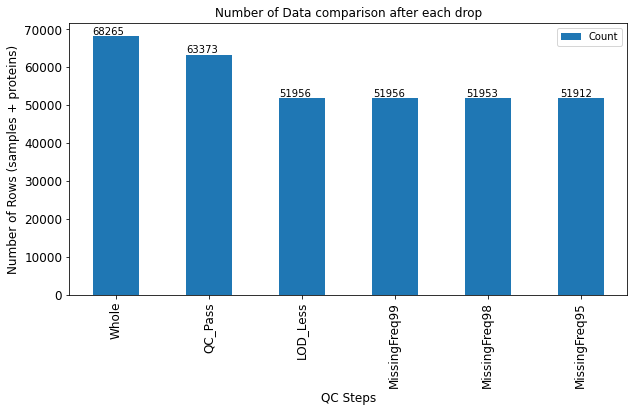

In [25]:
#plot the data drop
import matplotlib.pyplot as plt
ax = bar_1[['Count']].plot(kind='bar', title ="Number of Data comparison after each drop", figsize=(10, 5), legend=True, fontsize=12)
ax.set_xlabel("QC Steps", fontsize=12)
ax.set_ylabel("Number of Rows (samples + proteins)", fontsize=12)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.plot()
ax.figure.savefig(f'{datadir}/qcstep.png')

In [26]:
#####QC_WARNING ONLY

#drop columns not needed
pass_df = csf_cardio_bl_pass[['participant_id', 'Assay', 'NPX']].reset_index(drop=True)
#change dataframe into the format wanted by grouping by PATNO and ASSAY
pass_df = pass_df.groupby(['participant_id', 'Assay']).sum()
pass_df= pass_df['NPX'].unstack().reset_index().rename_axis(None, axis=1)

#change PATNO format
#csf_cardio_df['participant_id'] = csf_cardio_df['participant_id'].str.replace('MI','')
#rename PATNO to ID
pass_df.rename(columns={'participant_id':'ID'}, inplace=True)

#drop rows if ID is not in the list
pass_df = (pass_df[pass_df['ID'].isin(id_list)]).reset_index(drop=True)
# Save the csf_cardio_df
#csf_cardio_df.to_csv(r'./data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_ProteinCoding.csv', index=False)

pass_df

,ID,ACAN,ACE2,ACOX1,ACP5,ACTA2,ACY1,ADA2,ADAM15,ADAMTS13,...,VAMP5,VASN,VCAM1,VIM,VSIR,VSTM2L,VWF,WASF1,XG,ZBTB17
0,PD-PDAB411CTU,-0.9684,NaN,-0.2336,-1.3416,NaN,-2.9338,-1.6870,NaN,-6.1849,...,NaN,-1.9421,-1.7906,NaN,1.6514,NaN,-6.6061,NaN,-2.2783,NaN
1,PD-PDAE940EZ5,-0.2638,-3.0993,0.0940,-0.7612,-0.5682,-3.2224,-1.0228,0.6516,-6.5064,...,-0.2545,-1.6420,-1.9001,0.4669,2.1536,-0.3293,-6.4604,0.4236,-1.1918,-1.3527
2,PD-PDBB001EMM,-0.2691,-2.5923,0.4753,-0.9073,0.6244,-3.2537,-1.7862,0.4610,-6.0543,...,-0.1122,-1.9197,-2.0484,-0.5570,1.8787,0.0461,-5.9034,1.1415,-1.7551,-1.5858
3,PD-PDBD207ERC,-0.2186,-2.2076,-0.2373,-0.9850,0.3743,-4.0296,-1.0531,0.1732,-6.2396,...,0.3691,-2.0344,-2.4130,0.3064,1.6581,0.1378,-6.5725,0.6745,-1.4837,-1.2290
4,PD-PDBE283ED7,-0.7482,-2.4608,0.4592,-1.1386,0.4938,-3.8192,-1.5379,-0.3345,-6.9813,...,0.4421,-1.8531,-2.0534,1.1578,1.8495,-0.5586,-7.0291,0.1558,-1.7894,-1.4379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,PP-4101,NaN,-2.9955,NaN,-2.9708,-0.9182,NaN,-2.5498,-1.9558,-7.1215,...,-0.6496,-2.9493,-3.3377,1.0572,NaN,-0.7458,-7.3925,0.4933,-2.5734,-1.5569
163,PP-4102,1.1264,-2.7481,-0.2411,-0.0713,1.0216,-2.4635,-0.0434,1.5155,-5.5541,...,0.1112,-0.4028,-0.5248,0.9539,3.5693,0.2925,-6.4852,1.1730,-0.3224,-2.1825
164,PP-4103,0.2941,-2.2767,-0.4200,-0.6003,1.0781,-2.8720,-0.9954,0.9925,-5.5212,...,0.3818,-1.0520,-1.2619,0.1651,1.9987,-0.0593,-5.9440,0.8566,-1.7250,-0.7252
165,PP-4110,1.8005,-2.3871,1.1255,NaN,2.2759,-2.1434,NaN,1.2941,NaN,...,0.2781,NaN,NaN,0.2813,3.2130,-0.3990,NaN,1.1077,NaN,-1.4337


Max value: Count    158
dtype: int64
Min value: Count    151
dtype: int64
       Count
ACAN     151
ACE2     154
ACOX1    151
ACP5     158
ACTA2    154


<AxesSubplot:>

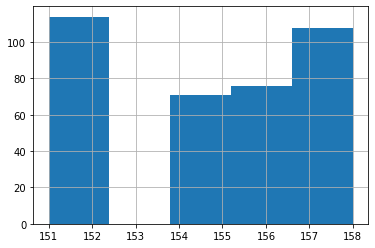

In [27]:
#count non null values per each protein (column)
pass_big = pd.DataFrame(pass_df.count(), columns = ['Count'])
pass_big = pass_big.iloc[1:]
print('Max value:' ,pass_big.max())
print('Min value:' ,pass_big.min())
print(pass_big.head())

#plot a histogram with 5 bins
pass_big.Count.hist(bins=5)
#plot = lod_big.plot(kind="hist")
#plot.set_xlabel("X")
#plot.set_ylabel("Y")

Max value: ID       PP-4121
Count        369
dtype: object
Min value: ID       PD-PDAB411CTU
Count              147
dtype: object
              ID  Count
0  PD-PDAB411CTU    298
1  PD-PDAE940EZ5    369
2  PD-PDBB001EMM    369
3  PD-PDBD207ERC    369
4  PD-PDBE283ED7    369


<AxesSubplot:>

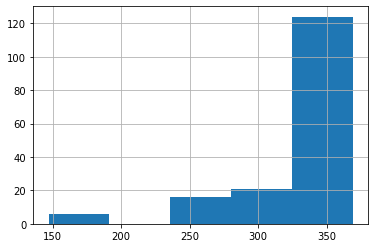

In [28]:
#count non null values per each row (samples)
pass_big_row = pd.DataFrame(pass_df[pass_df.columns[1:370]].count(axis=1), columns = ['Count'])
pass_big_row.insert(0, 'ID', pass_df['ID'])
print('Max value:' ,pass_big_row.max())
print('Min value:' ,pass_big_row.min())
print(pass_big_row.head())

#plot a histogram with 5 bins
pass_big_row.Count.hist(bins=5)
#plot = lod_big.plot(kind="hist")
#plot.set_xlabel("X")
#plot.set_ylabel("Y")

In [29]:
#count how many null values per protein
#(csf_cardio_df.isna().sum() > 37).value_counts()
#total number of rows are 167
print('Columns that has null value more than 8%: ', (pass_df.isnull().mean() > .08).values.sum())
#csf_cardio_df.columns[csf_cardio_df.isnull().sum() > 0.5*csf_cardio_df.shape[0]].nunique()
print('Columns that has null value more than 10%: ', (pass_df.isnull().mean() > .1).values.sum())
print('Columns that has null value more than 15%: ', (pass_df.isnull().mean() > .15).values.sum())
#csf_cardio_df.isna().sum()

#total number of columns are 370
print('Rows that has null value more than 30%: ', (pass_df.isnull().mean(axis=1) > .3).values.sum())
print('Rows that has null value more than 40%: ', (pass_df.isnull().mean(axis=1) > .4).values.sum())
print('Rows that has null value more than 50%: ', (pass_df.isnull().mean(axis=1) > .5).values.sum())

Columns that has null value more than 8%:  114
Columns that has null value more than 10%:  0
Columns that has null value more than 15%:  0
Rows that has null value more than 30%:  18
Rows that has null value more than 40%:  6
Rows that has null value more than 50%:  4


In [30]:
####QC_WARNING & LOD DROP

#drop columns not needed
pass_lod_df = csf_cardio_bl_pass_npx[['participant_id', 'Assay', 'NPX']].reset_index(drop=True)
#change dataframe into the format wanted by grouping by PATNO and ASSAY
pass_lod_df = pass_lod_df.groupby(['participant_id', 'Assay']).sum()
pass_lod_df= pass_lod_df['NPX'].unstack().reset_index().rename_axis(None, axis=1)

#change PATNO format
#csf_cardio_df['participant_id'] = csf_cardio_df['participant_id'].str.replace('MI','')
#rename PATNO to ID
pass_lod_df.rename(columns={'participant_id':'ID'}, inplace=True)

#drop rows if ID is not in the list
pass_lod_df = (pass_lod_df[pass_lod_df['ID'].isin(id_list)]).reset_index(drop=True)
# Save the csf_cardio_df
#csf_cardio_df.to_csv(r'./data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_ProteinCoding.csv', index=False)

pass_lod_df

,ID,ACAN,ACE2,ACOX1,ACP5,ACTA2,ACY1,ADA2,ADAM15,ADAMTS13,...,USP8,VAMP5,VASN,VCAM1,VSIR,VSTM2L,VWF,WASF1,XG,ZBTB17
0,PD-PDAB411CTU,-0.9684,NaN,NaN,-1.3416,NaN,-2.9338,-1.6870,NaN,-6.1849,...,NaN,NaN,-1.9421,-1.7906,1.6514,NaN,-6.6061,NaN,-2.2783,NaN
1,PD-PDAE940EZ5,-0.2638,NaN,NaN,-0.7612,-0.5682,-3.2224,-1.0228,0.6516,-6.5064,...,-2.9937,NaN,-1.6420,-1.9001,2.1536,-0.3293,-6.4604,NaN,-1.1918,NaN
2,PD-PDBB001EMM,-0.2691,NaN,NaN,-0.9073,0.6244,-3.2537,-1.7862,0.4610,-6.0543,...,-2.6705,NaN,-1.9197,-2.0484,1.8787,0.0461,-5.9034,1.1415,-1.7551,NaN
3,PD-PDBD207ERC,-0.2186,-2.2076,NaN,-0.9850,0.3743,-4.0296,-1.0531,0.1732,-6.2396,...,-2.5751,0.3691,-2.0344,-2.4130,1.6581,NaN,-6.5725,NaN,-1.4837,NaN
4,PD-PDBE283ED7,-0.7482,NaN,0.4592,-1.1386,0.4938,-3.8192,-1.5379,-0.3345,-6.9813,...,-2.6415,0.4421,-1.8531,-2.0534,1.8495,NaN,-7.0291,NaN,-1.7894,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,PP-4101,NaN,NaN,NaN,-2.9708,NaN,NaN,-2.5498,-1.9558,NaN,...,NaN,NaN,-2.9493,-3.3377,NaN,NaN,-7.3925,0.4933,-2.5734,NaN
163,PP-4102,1.1264,NaN,NaN,-0.0713,1.0216,-2.4635,-0.0434,1.5155,-5.5541,...,-2.8789,0.1112,-0.4028,-0.5248,3.5693,0.2925,-6.4852,1.1730,-0.3224,NaN
164,PP-4103,0.2941,NaN,NaN,-0.6003,1.0781,-2.8720,-0.9954,0.9925,-5.5212,...,-2.6211,0.3818,-1.0520,-1.2619,1.9987,-0.0593,-5.9440,NaN,-1.7250,-0.7252
165,PP-4110,1.8005,NaN,1.1255,NaN,2.2759,-2.1434,NaN,1.2941,NaN,...,-2.7680,NaN,NaN,NaN,3.2130,NaN,NaN,1.1077,NaN,NaN


Max value: Count    158
dtype: int64
Min value: Count    0
dtype: int64
       Count
ACAN     151
ACE2       9
ACOX1     11
ACP5     158
ACTA2    145


<AxesSubplot:>

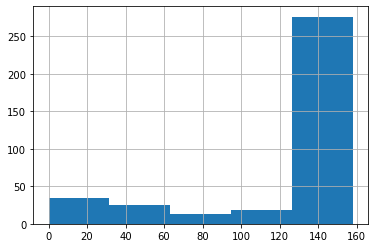

In [31]:
#count non null values per each protein (column)
pass_lod_big = pd.DataFrame(pass_lod_df.count(), columns = ['Count'])
pass_lod_big = pass_lod_big.iloc[1:]
print('Max value:' ,pass_lod_big.max())
print('Min value:' ,pass_lod_big.min())
print(pass_lod_big.head())

#plot a histogram with 5 bins
pass_lod_big.Count.hist(bins=5)
#plot = lod_big.plot(kind="hist")
#plot.set_xlabel("X")
#plot.set_ylabel("Y")

Max value: ID       PP-4121
Count        340
dtype: object
Min value: ID       PD-PDAB411CTU
Count              101
dtype: object
              ID  Count
0  PD-PDAB411CTU    270
1  PD-PDAE940EZ5    297
2  PD-PDBB001EMM    298
3  PD-PDBD207ERC    302
4  PD-PDBE283ED7    296


<AxesSubplot:>

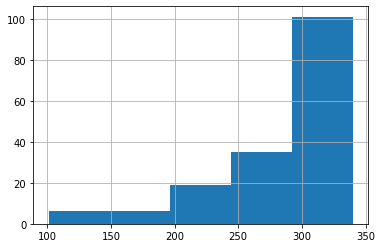

In [32]:
#count non null values per each row (samples)
pass_lod_big_row = pd.DataFrame(pass_lod_df[pass_lod_df.columns[1:368]].count(axis=1), columns = ['Count'])
pass_lod_big_row.insert(0, 'ID', pass_lod_df['ID'])
print('Max value:' ,pass_lod_big_row.max())
print('Min value:' ,pass_lod_big_row.min())
print(pass_lod_big_row.head())

#plot a histogram with 5 bins
pass_lod_big_row.Count.hist(bins=5)
#plot = lod_big.plot(kind="hist")
#plot.set_xlabel("X")
#plot.set_ylabel("Y")

In [76]:
#count how many null values per protein
#(csf_cardio_df.isna().sum() > 37).value_counts()
#total number of rows are 167
print('Columns that has null value more than 50%: ', (pass_lod_df.isnull().mean() > .5).values.sum())
#csf_onc_df.columns[csf_onc_df.isnull().sum() > 0.5*csf_onc_df.shape[0]].nunique()
print('Columns that has null value more than 60%: ', (pass_lod_df.isnull().mean() > .6).values.sum())
print('Columns that has null value more than 70%: ', (pass_lod_df.isnull().mean() > .7).values.sum())
#print('Columns that has null value more than 90%: ', (pass_lod_df.isna().sum() > 150).values.sum())
#csf_cardio_df.isna().sum()

#total number of columns are 368
print('Rows that has null value more than 50%: ', (pass_lod_df.isnull().mean(axis=1) > .5).values.sum())
print('Rows that has null value more than 60%: ', (pass_lod_df.isnull().mean(axis=1) > .6).values.sum())
print('Rows that has null value more than 70%: ', (pass_lod_df.isnull().mean(axis=1) > .7).values.sum())
#print('Rows that has null value more than 70%: ', (pass_lod_df.isna().sum(axis=1) > 251).values.sum())

Columns that has null value more than 50%:  69
Columns that has null value more than 60%:  62
Columns that has null value more than 70%:  49
Rows that has null value more than 50%:  7
Rows that has null value more than 60%:  6
Rows that has null value more than 70%:  3


In [34]:
####QC_WARNING & MISSING FREQ 95 DROP

#drop rows with MISSINGFREQ bigger than .95
csf_cardio_bl_pass_fq = csf_cardio_bl_pass[csf_cardio_bl_pass['MissingFreq'] <= 0.95].reset_index(drop=True)

#drop columns not needed
pass_fq_df = csf_cardio_bl_pass_fq[['participant_id', 'Assay', 'NPX']].reset_index(drop=True)
#change dataframe into the format wanted by grouping by PATNO and ASSAY
pass_fq_df = pass_fq_df.groupby(['participant_id', 'Assay']).sum()
pass_fq_df= pass_fq_df['NPX'].unstack().reset_index().rename_axis(None, axis=1)

#change PATNO format
#csf_cardio_df['participant_id'] = csf_cardio_df['participant_id'].str.replace('MI','')
#rename PATNO to ID
pass_fq_df.rename(columns={'participant_id':'ID'}, inplace=True)

#drop rows if ID is not in the list
pass_fq_df = (pass_fq_df[pass_fq_df['ID'].isin(id_list)]).reset_index(drop=True)
# Save the csf_cardio_df
#csf_cardio_df.to_csv(r'./data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_ProteinCoding.csv', index=False)

pass_fq_df

,ID,ACAN,ACE2,ACOX1,ACP5,ACTA2,ACY1,ADA2,ADAM15,ADAMTS13,...,USP8,VAMP5,VASN,VCAM1,VSIR,VSTM2L,VWF,WASF1,XG,ZBTB17
0,PD-PDAB411CTU,-0.9684,NaN,-0.2336,-1.3416,NaN,-2.9338,-1.6870,NaN,-6.1849,...,NaN,NaN,-1.9421,-1.7906,1.6514,NaN,-6.6061,NaN,-2.2783,NaN
1,PD-PDAE940EZ5,-0.2638,-3.0993,0.0940,-0.7612,-0.5682,-3.2224,-1.0228,0.6516,-6.5064,...,-2.9937,-0.2545,-1.6420,-1.9001,2.1536,-0.3293,-6.4604,0.4236,-1.1918,-1.3527
2,PD-PDBB001EMM,-0.2691,-2.5923,0.4753,-0.9073,0.6244,-3.2537,-1.7862,0.4610,-6.0543,...,-2.6705,-0.1122,-1.9197,-2.0484,1.8787,0.0461,-5.9034,1.1415,-1.7551,-1.5858
3,PD-PDBD207ERC,-0.2186,-2.2076,-0.2373,-0.9850,0.3743,-4.0296,-1.0531,0.1732,-6.2396,...,-2.5751,0.3691,-2.0344,-2.4130,1.6581,0.1378,-6.5725,0.6745,-1.4837,-1.2290
4,PD-PDBE283ED7,-0.7482,-2.4608,0.4592,-1.1386,0.4938,-3.8192,-1.5379,-0.3345,-6.9813,...,-2.6415,0.4421,-1.8531,-2.0534,1.8495,-0.5586,-7.0291,0.1558,-1.7894,-1.4379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,PP-4101,NaN,-2.9955,NaN,-2.9708,-0.9182,NaN,-2.5498,-1.9558,-7.1215,...,-4.5273,-0.6496,-2.9493,-3.3377,NaN,-0.7458,-7.3925,0.4933,-2.5734,-1.5569
163,PP-4102,1.1264,-2.7481,-0.2411,-0.0713,1.0216,-2.4635,-0.0434,1.5155,-5.5541,...,-2.8789,0.1112,-0.4028,-0.5248,3.5693,0.2925,-6.4852,1.1730,-0.3224,-2.1825
164,PP-4103,0.2941,-2.2767,-0.4200,-0.6003,1.0781,-2.8720,-0.9954,0.9925,-5.5212,...,-2.6211,0.3818,-1.0520,-1.2619,1.9987,-0.0593,-5.9440,0.8566,-1.7250,-0.7252
165,PP-4110,1.8005,-2.3871,1.1255,NaN,2.2759,-2.1434,NaN,1.2941,NaN,...,-2.7680,0.2781,NaN,NaN,3.2130,-0.3990,NaN,1.1077,NaN,-1.4337


Max value: Count    158
dtype: int64
Min value: Count    151
dtype: int64
       Count
ACAN     151
ACE2     154
ACOX1    151
ACP5     158
ACTA2    154


<AxesSubplot:>

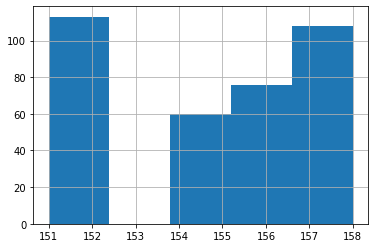

In [35]:
#count non null values per each protein (column)
pass_fq_big = pd.DataFrame(pass_fq_df.count(), columns = ['Count'])
pass_fq_big = pass_fq_big.iloc[1:]
print('Max value:' ,pass_fq_big.max())
print('Min value:' ,pass_fq_big.min())
print(pass_fq_big.head())

#plot a histogram with 5 bins
pass_fq_big.Count.hist(bins=5)
#plot = lod_big.plot(kind="hist")
#plot.set_xlabel("X")
#plot.set_ylabel("Y")

Max value: ID       PP-4121
Count        357
dtype: object
Min value: ID       PD-PDAB411CTU
Count              136
dtype: object
              ID  Count
0  PD-PDAB411CTU    297
1  PD-PDAE940EZ5    357
2  PD-PDBB001EMM    357
3  PD-PDBD207ERC    357
4  PD-PDBE283ED7    357


<AxesSubplot:>

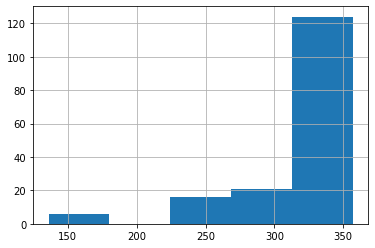

In [36]:
#count non null values per each row (samples)
pass_fq_big_row = pd.DataFrame(pass_fq_df[pass_fq_df.columns[1:368]].count(axis=1), columns = ['Count'])
pass_fq_big_row.insert(0, 'ID', pass_fq_df['ID'])
print('Max value:' ,pass_fq_big_row.max())
print('Min value:' ,pass_fq_big_row.min())
print(pass_fq_big_row.head())

#plot a histogram with 5 bins
pass_fq_big_row.Count.hist(bins=5)
#plot = lod_big.plot(kind="hist")
#plot.set_xlabel("X")
#plot.set_ylabel("Y")

In [37]:
#count how many null values per protein
#(csf_cardio_df.isna().sum() > 37).value_counts()
#total number of rows are 167
print('Columns that has null value more than 8%: ', (pass_fq_df.isnull().mean() > .08).values.sum())
#csf_cardio_df.columns[csf_cardio_df.isnull().sum() > 0.5*csf_cardio_df.shape[0]].nunique()
print('Columns that has null value more than 10%: ', (pass_fq_df.isnull().mean() > .1).values.sum())
print('Columns that has null value more than 15%: ', (pass_fq_df.isnull().mean() > .15).values.sum())
#csf_cardio_df.isna().sum()

#total number of columns are 358
print('Rows that has null value more than 50%: ', (pass_fq_df.isnull().mean(axis=1) > .5).values.sum())
print('Rows that has null value more than 60%: ', (pass_fq_df.isnull().mean(axis=1) > .6).values.sum())
print('Rows that has null value more than 70%: ', (pass_fq_df.isnull().mean(axis=1) > .7).values.sum())

Columns that has null value more than 8%:  113
Columns that has null value more than 10%:  0
Columns that has null value more than 15%:  0
Rows that has null value more than 50%:  6
Rows that has null value more than 60%:  3
Rows that has null value more than 70%:  0


In [38]:
#####QC_WARNING, LOD, MISSING FREQUENCY 95 DROP

#drop columns not needed
csf_cardio_df = csf_cardio_bl_pass_npx_fq[['participant_id', 'Assay', 'NPX']].reset_index(drop=True)
#change dataframe into the format wanted by grouping by PATNO and ASSAY
csf_cardio_df = csf_cardio_df.groupby(['participant_id', 'Assay']).sum()
csf_cardio_df = csf_cardio_df['NPX'].unstack().reset_index().rename_axis(None, axis=1)

#change PATNO format
#csf_cardio_df['participant_id'] = csf_cardio_df['participant_id'].str.replace('MI','')
#rename PATNO to ID
csf_cardio_df.rename(columns={'participant_id':'ID'}, inplace=True)

#drop rows if ID is not in the list
csf_cardio_df = (csf_cardio_df[csf_cardio_df['ID'].isin(id_list)]).reset_index(drop=True)
# Save the csf_cardio_df
csf_cardio_df.to_csv(r'./data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_ProteinCoding.csv', index=False)

csf_cardio_df

,ID,ACAN,ACE2,ACOX1,ACP5,ACTA2,ACY1,ADA2,ADAM15,ADAMTS13,...,USP8,VAMP5,VASN,VCAM1,VSIR,VSTM2L,VWF,WASF1,XG,ZBTB17
0,PD-PDAB411CTU,-0.9684,NaN,NaN,-1.3416,NaN,-2.9338,-1.6870,NaN,-6.1849,...,NaN,NaN,-1.9421,-1.7906,1.6514,NaN,-6.6061,NaN,-2.2783,NaN
1,PD-PDAE940EZ5,-0.2638,NaN,NaN,-0.7612,-0.5682,-3.2224,-1.0228,0.6516,-6.5064,...,-2.9937,NaN,-1.6420,-1.9001,2.1536,-0.3293,-6.4604,NaN,-1.1918,NaN
2,PD-PDBB001EMM,-0.2691,NaN,NaN,-0.9073,0.6244,-3.2537,-1.7862,0.4610,-6.0543,...,-2.6705,NaN,-1.9197,-2.0484,1.8787,0.0461,-5.9034,1.1415,-1.7551,NaN
3,PD-PDBD207ERC,-0.2186,-2.2076,NaN,-0.9850,0.3743,-4.0296,-1.0531,0.1732,-6.2396,...,-2.5751,0.3691,-2.0344,-2.4130,1.6581,NaN,-6.5725,NaN,-1.4837,NaN
4,PD-PDBE283ED7,-0.7482,NaN,0.4592,-1.1386,0.4938,-3.8192,-1.5379,-0.3345,-6.9813,...,-2.6415,0.4421,-1.8531,-2.0534,1.8495,NaN,-7.0291,NaN,-1.7894,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,PP-4101,NaN,NaN,NaN,-2.9708,NaN,NaN,-2.5498,-1.9558,NaN,...,NaN,NaN,-2.9493,-3.3377,NaN,NaN,-7.3925,0.4933,-2.5734,NaN
163,PP-4102,1.1264,NaN,NaN,-0.0713,1.0216,-2.4635,-0.0434,1.5155,-5.5541,...,-2.8789,0.1112,-0.4028,-0.5248,3.5693,0.2925,-6.4852,1.1730,-0.3224,NaN
164,PP-4103,0.2941,NaN,NaN,-0.6003,1.0781,-2.8720,-0.9954,0.9925,-5.5212,...,-2.6211,0.3818,-1.0520,-1.2619,1.9987,-0.0593,-5.9440,NaN,-1.7250,-0.7252
165,PP-4110,1.8005,NaN,1.1255,NaN,2.2759,-2.1434,NaN,1.2941,NaN,...,-2.7680,NaN,NaN,NaN,3.2130,NaN,NaN,1.1077,NaN,NaN


Max value: Count    158
dtype: int64
Min value: Count    3
dtype: int64
       Count
ACAN     151
ACE2       9
ACOX1     11
ACP5     158
ACTA2    145


<AxesSubplot:>

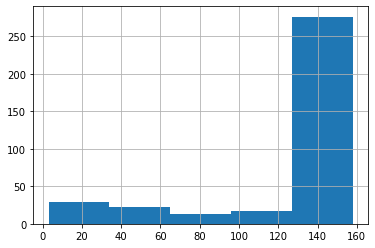

In [39]:
#count non null values per each protein (column)
lod_fq_big = pd.DataFrame(csf_cardio_df.count(), columns = ['Count'])
lod_fq_big = lod_fq_big.iloc[1:]
print('Max value:' ,lod_fq_big.max())
print('Min value:' ,lod_fq_big.min())
print(lod_fq_big.head())

#plot a histogram with 5 bins
lod_fq_big.Count.hist(bins=5)
#plot = lod_big.plot(kind="hist")
#plot.set_xlabel("X")
#plot.set_ylabel("Y")

Max value: ID       PP-4121
Count        338
dtype: object
Min value: ID       PD-PDAB411CTU
Count              101
dtype: object
              ID  Count
0  PD-PDAB411CTU    270
1  PD-PDAE940EZ5    297
2  PD-PDBB001EMM    298
3  PD-PDBD207ERC    300
4  PD-PDBE283ED7    296


<AxesSubplot:>

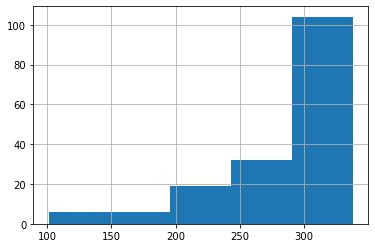

In [40]:
#count non null values per each row (samples)
lod_fq_big_row = pd.DataFrame(csf_cardio_df[csf_cardio_df.columns[1:358]].count(axis=1), columns = ['Count'])
lod_fq_big_row.insert(0, 'ID', csf_cardio_df['ID'])
print('Max value:' ,lod_fq_big_row.max())
print('Min value:' ,lod_fq_big_row.min())
print(lod_fq_big_row.head())

#plot a histogram with 5 bins
lod_fq_big_row.Count.hist(bins=5)
#plot = lod_big.plot(kind="hist")
#plot.set_xlabel("X")
#plot.set_ylabel("Y")

In [41]:
print('Columns that has null value less than 5%: ', (csf_cardio_df.isna().sum() < 8).values.sum())
#csf_cardio_df.isna().sum()

#total number of columns are 358
print('Rows that has null value less than 5%: ', (csf_cardio_df.isna().sum(axis=1) < 18).values.sum())

Columns that has null value less than 5%:  1
Rows that has null value less than 5%:  0


In [42]:
#count how many null values per protein
#(csf_cardio_df.isna().sum() > 37).value_counts()
#total number of rows are 167
print('Columns that has null value more than 50%: ', (csf_cardio_df.isnull().mean() > .5).values.sum())
#csf_onc_df.columns[csf_onc_df.isnull().sum() > 0.5*csf_onc_df.shape[0]].nunique()
print('Columns that has null value more than 60%: ', (csf_cardio_df.isnull().mean() > .6).values.sum())
print('Columns that has null value more than 70%: ', (csf_cardio_df.isnull().mean() > .7).values.sum())
#print('Columns that has null value more than 90%: ', (pass_lod_df.isna().sum() > 150).values.sum())
#csf_cardio_df.isna().sum()

#total number of columns are 358
print('Rows that has null value more than 50%: ', (csf_cardio_df.isnull().mean(axis=1) > .5).values.sum())
print('Rows that has null value more than 60%: ', (csf_cardio_df.isnull().mean(axis=1) > .6).values.sum())
print('Rows that has null value more than 70%: ', (csf_cardio_df.isnull().mean(axis=1) > .7).values.sum())
#print('Rows that has null value more than 70%: ', (pass_lod_df.isna().sum(axis=1) > 251).values.sum())

Columns that has null value more than 50%:  59
Columns that has null value more than 75%:  33
Columns that has null value more than 90%:  12
Rows that has null value more than 50%:  6
Rows that has null value more than 60%:  6
Rows that has null value more than 70%:  3


In [43]:
#count how many null values per protein for QC_CONTROL AND MISSING FREQUENCY
#(csf_cardio_df.isna().sum() > 37).value_counts()
#total number of rows are 167
print('Columns that has null value more than 50%: ', (pass_fq_df.isnull().mean() > .5).values.sum())
#csf_cardio_df.columns[csf_cardio_df.isnull().sum() > 0.5*csf_cardio_df.shape[0]].nunique()
print('Columns that has null value more than 75%: ', (pass_fq_df.isnull().mean() > .75).values.sum())
print('Columns that has null value more than 90%: ', (pass_fq_df.isnull().mean() > .9).values.sum())
#csf_cardio_df.isna().sum()

#total number of columns are 358
print('Rows that has null value more than 50%: ', (pass_fq_df.isnull().mean(axis=1) > .5).values.sum())
print('Rows that has null value more than 60%: ', (pass_fq_df.isnull().mean(axis=1) > .6).values.sum())
print('Rows that has null value more than 70%: ', (pass_fq_df.isnull().mean(axis=1) > .7).values.sum())

Columns that has null value more than 50%:  0
Columns that has null value more than 75%:  0
Columns that has null value more than 90%:  0
Rows that has null value more than 50%:  6
Rows that has null value more than 60%:  3
Rows that has null value more than 70%:  0


In [44]:
#drop null value threshold rows or columns and save
#drop columns that have more than 50% null values
df_csf_cardio = csf_cardio_df[csf_cardio_df.columns[csf_cardio_df.isnull().mean() <= 0.5]]
###df = csf_cardio_df.loc[:,csf_cardio_df.isnull().mean() < .5] --> this is same as the one above
###df = csf_cardio_df.loc[:,csf_cardio_df.isnull().sum()  < .5*df.shape[0]] --> this is same as the one above
#drop rows that have more than 50% null values
df_csf_cardio = df_csf_cardio.dropna(thresh=df_csf_cardio.shape[1]*0.5, how='all',axis=0)
df_csf_cardio

,ID,ACAN,ACP5,ACTA2,ACY1,ADA2,ADAM15,ADAMTS13,ADAMTS16,ADGRG2,...,TNFSF13B,TYMP,TYRO3,UMOD,USP8,VASN,VCAM1,VSIR,VWF,XG
0,PD-PDAB411CTU,-0.9684,-1.3416,NaN,-2.9338,-1.6870,NaN,-6.1849,NaN,-3.3623,...,0.7371,-2.8480,4.1588,-4.9864,NaN,-1.9421,-1.7906,1.6514,-6.6061,-2.2783
1,PD-PDAE940EZ5,-0.2638,-0.7612,-0.5682,-3.2224,-1.0228,0.6516,-6.5064,-0.9787,-2.9396,...,1.6361,-2.5168,4.2860,-4.9891,-2.9937,-1.6420,-1.9001,2.1536,-6.4604,-1.1918
2,PD-PDBB001EMM,-0.2691,-0.9073,0.6244,-3.2537,-1.7862,0.4610,-6.0543,-1.1004,-3.2754,...,0.8319,-2.6834,4.4426,-5.7069,-2.6705,-1.9197,-2.0484,1.8787,-5.9034,-1.7551
3,PD-PDBD207ERC,-0.2186,-0.9850,0.3743,-4.0296,-1.0531,0.1732,-6.2396,NaN,-3.5442,...,1.1145,-1.8886,3.9511,-4.9485,-2.5751,-2.0344,-2.4130,1.6581,-6.5725,-1.4837
4,PD-PDBE283ED7,-0.7482,-1.1386,0.4938,-3.8192,-1.5379,-0.3345,-6.9813,-0.7797,-3.2838,...,0.8503,-3.0068,4.2567,NaN,-2.6415,-1.8531,-2.0534,1.8495,-7.0291,-1.7894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,PP-4099,-0.9565,-1.8769,0.0316,-3.6525,-0.9352,-0.0641,-6.7625,-1.1672,-3.8782,...,0.1027,-2.9536,3.8016,-5.5053,-3.1825,-2.5144,-2.3874,1.3341,-6.9279,-2.2132
162,PP-4101,NaN,-2.9708,NaN,NaN,-2.5498,-1.9558,NaN,NaN,NaN,...,-0.5046,NaN,NaN,-6.1232,NaN,-2.9493,-3.3377,NaN,-7.3925,-2.5734
163,PP-4102,1.1264,-0.0713,1.0216,-2.4635,-0.0434,1.5155,-5.5541,-0.7992,-2.3757,...,2.7286,-0.9898,4.6375,-3.8687,-2.8789,-0.4028,-0.5248,3.5693,-6.4852,-0.3224
164,PP-4103,0.2941,-0.6003,1.0781,-2.8720,-0.9954,0.9925,-5.5212,-0.6657,-2.8593,...,1.3427,-1.8019,4.2948,-5.3961,-2.6211,-1.0520,-1.2619,1.9987,-5.9440,-1.7250


In [45]:
#drop null value threshold rows or columns and save for QC_CONTROL AND MISSING FREQUENCY
#drop columns that have more than 50% null values
df_csf_cardio_1 = pass_fq_df[pass_fq_df.columns[pass_fq_df.isnull().mean() <= 0.5]]
###df = csf_cardio_df.loc[:,csf_cardio_df.isnull().mean() < .5] --> this is same as the one above
###df = csf_cardio_df.loc[:,csf_cardio_df.isnull().sum()  < .5*df.shape[0]] --> this is same as the one above
#drop rows that have more than 50% null values
df_csf_cardio_1 = df_csf_cardio_1.dropna(thresh=df_csf_cardio_1.shape[1]*0.5, how='all',axis=0)
df_csf_cardio_1

,ID,ACAN,ACE2,ACOX1,ACP5,ACTA2,ACY1,ADA2,ADAM15,ADAMTS13,...,USP8,VAMP5,VASN,VCAM1,VSIR,VSTM2L,VWF,WASF1,XG,ZBTB17
0,PD-PDAB411CTU,-0.9684,NaN,-0.2336,-1.3416,NaN,-2.9338,-1.6870,NaN,-6.1849,...,NaN,NaN,-1.9421,-1.7906,1.6514,NaN,-6.6061,NaN,-2.2783,NaN
1,PD-PDAE940EZ5,-0.2638,-3.0993,0.0940,-0.7612,-0.5682,-3.2224,-1.0228,0.6516,-6.5064,...,-2.9937,-0.2545,-1.6420,-1.9001,2.1536,-0.3293,-6.4604,0.4236,-1.1918,-1.3527
2,PD-PDBB001EMM,-0.2691,-2.5923,0.4753,-0.9073,0.6244,-3.2537,-1.7862,0.4610,-6.0543,...,-2.6705,-0.1122,-1.9197,-2.0484,1.8787,0.0461,-5.9034,1.1415,-1.7551,-1.5858
3,PD-PDBD207ERC,-0.2186,-2.2076,-0.2373,-0.9850,0.3743,-4.0296,-1.0531,0.1732,-6.2396,...,-2.5751,0.3691,-2.0344,-2.4130,1.6581,0.1378,-6.5725,0.6745,-1.4837,-1.2290
4,PD-PDBE283ED7,-0.7482,-2.4608,0.4592,-1.1386,0.4938,-3.8192,-1.5379,-0.3345,-6.9813,...,-2.6415,0.4421,-1.8531,-2.0534,1.8495,-0.5586,-7.0291,0.1558,-1.7894,-1.4379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,PP-4099,-0.9565,-2.4790,0.2691,-1.8769,0.0316,-3.6525,-0.9352,-0.0641,-6.7625,...,-3.1825,-0.0298,-2.5144,-2.3874,1.3341,0.4160,-6.9279,0.7027,-2.2132,-0.7924
162,PP-4101,NaN,-2.9955,NaN,-2.9708,-0.9182,NaN,-2.5498,-1.9558,-7.1215,...,-4.5273,-0.6496,-2.9493,-3.3377,NaN,-0.7458,-7.3925,0.4933,-2.5734,-1.5569
163,PP-4102,1.1264,-2.7481,-0.2411,-0.0713,1.0216,-2.4635,-0.0434,1.5155,-5.5541,...,-2.8789,0.1112,-0.4028,-0.5248,3.5693,0.2925,-6.4852,1.1730,-0.3224,-2.1825
164,PP-4103,0.2941,-2.2767,-0.4200,-0.6003,1.0781,-2.8720,-0.9954,0.9925,-5.5212,...,-2.6211,0.3818,-1.0520,-1.2619,1.9987,-0.0593,-5.9440,0.8566,-1.7250,-0.7252


In [46]:
#save the data as csv file
df_csf_cardio_1.to_csv(r'./data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_ProteinCoding.csv', index=False)

GenoML to munge the data

In [47]:
# Use GenoML to construct the .h5 that will be used for adjusting (GenoML will normalize and munge the data as well)
WORK_DIR="/data/songy4/proteomics_196/data_folder"

!genoml discrete supervised munge \
--prefix $WORK_DIR/PDBP_PPMI_Proteomics_196_PreAdjust_csf_cardio \
--pheno $WORK_DIR/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_pheno.csv \
--addit $WORK_DIR/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_ProteinCoding.csv \
--impute mean


---> Running genoml discrete supervised munge

---> ---> Dependency Check

---> ---> ---> Checking plink
---> ---> Dependency Check: [Done]

---> ---> Dependency Check

---> ---> ---> Checking plink
---> ---> Dependency Check: [Done]

Here is some basic info on the command you are about to run.
Python version info...
3.7.5 | packaged by conda-forge | (default, Jan 28 2021, 18:46:00) 
[GCC 9.3.0]
CLI argument info...
The output prefix for this run is /data/songy4/proteomics_196/data_folder/PDBP_PPMI_Proteomics_196_PreAdjust_csf_cardio and will be appended to later runs of GenoML.
Working with genotype data? None
Do you want GenoML to prune your SNPs for you? no
The pruning threshold you've chosen is 0.5
Working with additional predictors? /data/songy4/proteomics_196/data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_ProteinCoding.csv
Where is your phenotype file? /data/songy4/proteomics_196/data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_pheno.csv
Any use for an 

Adjust the munged data

In [48]:
munged_data = "/data/songy4/proteomics_196/data_folder/PDBP_PPMI_Proteomics_196_PreAdjust_csf_cardio.dataForML.h5"
target_data_df = pd.read_hdf(munged_data, 'dataForML')
target_data_df.shape

(161, 359)

In [49]:
# Adjust omics data 

munged_data = "/data/songy4/proteomics_196/data_folder/PDBP_PPMI_Proteomics_196_PreAdjust_csf_cardio.dataForML.h5"
target_columns = "/data/songy4/proteomics_196/data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_panel.txt"
confounders = "/data/songy4/proteomics_196/data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_10PCs_loadings.csv"

target_data_df = pd.read_hdf(munged_data, 'dataForML')
target_column_df = pd.read_csv(target_columns, names=['TARGETS'])

confounders_df = pd.read_csv(confounders)
confounders_df.drop(columns=['PHENO'], inplace=True)

# Keep only intersecting feature names left in munged set (removed either because --gwas or std dev of 0 etc.)
target_data_list = target_data_df.columns
target_column_list = target_column_df['TARGETS'].tolist()
intersecting_list = list(set(target_data_list).intersection(set(target_column_list)))
target_column_df = pd.DataFrame(intersecting_list,columns=['TARGETS'])

#print(len(intersecting_list))
#print(intersecting_list[:10])
#print(target_data_df.head())
#print(target_data_df.shape)

normalize_switch = 'yes' # Yep or nope to run the Z normalization of residuals.

# Munging begins. First make feature lists for targets and confounders. Then merge datasets.

target_list = list(target_column_df['TARGETS'])
confounder_list = list(confounders_df.columns[1:])
columns_to_keep_list = list(target_data_df.columns)

adjustments_df = target_data_df.merge(confounders_df, how='inner', on='ID', suffixes=['', '_y'])

# Here is where we start the adjusting

## First, make the formula pieces
formula_for_confounders = ' + '.join(confounder_list)

for target in target_list:
    current_target = str(target)
    #print("working on " + current_target)
    current_formula = current_target + " ~ " + formula_for_confounders
    #print(current_formula)
    target_model = smf.ols(formula=current_formula, data=adjustments_df).fit()
    if normalize_switch == 'yes':
        adjustments_df['temp'] = pd.to_numeric(target_model.resid)
        #print(type(adjustments_df['temp']))
        mean_scalar = adjustments_df['temp'].mean()
        sd_scalar = adjustments_df['temp'].std()
        adjustments_df[current_target] = (adjustments_df['temp'] - mean_scalar)/sd_scalar
        adjustments_df.drop(columns=['temp'], inplace=True)
    else:
        adjustments_df[current_target] = pd.to_numeric(target_model.resid)

# Now some more munging to just extract columns that are in original dataset
adjusted_df = adjustments_df[columns_to_keep_list]

# Save as an --addit file format
adjusted_df.to_csv("/data/songy4/proteomics_196/data_folder/PDBP_PPMI_Proteomics_196_PreAdjust_csf_cardio_ADJUSTED10PCs.csv", index=False)

In [7]:
#read one of the file
csf_cardio_df = pd.read_csv(f"{datadir}/PDBP_PPMI_Proteomics_196_PreAdjust_csf_cardio_ADJUSTED10PCs.csv", engine='c', index_col=False)
print('shape of csf_cardio_df :', csf_cardio_df .shape)
csf_cardio_df 

shape of csf_cardio_df : (161, 359)


,ID,PHENO,ACAN,ACE2,ACOX1,ACP5,ACTA2,ACY1,ADA2,ADAM15,...,USP8,VAMP5,VASN,VCAM1,VSIR,VSTM2L,VWF,WASF1,XG,ZBTB17
0,PD-PDAB411CTU,0,-0.752802,0.467488,-0.384287,-0.811119,1.431232,0.907265,-1.582658,0.949988,...,0.855608,0.374279,-0.136669,0.171961,-0.667227,0.596417,0.054341,0.775795,-2.088095,-0.003571
1,PD-PDAE940EZ5,0,0.737035,-2.192122,-0.218087,0.832711,-1.368604,-0.268686,0.109457,0.795378,...,0.257256,-0.837988,-0.097955,-0.493465,0.323012,-0.086527,0.670980,-0.780521,0.543373,-0.229871
2,PD-PDBB001EMM,0,-0.009438,-0.700961,1.219118,0.522055,0.082149,0.133229,-1.972872,0.298210,...,0.337104,-1.182885,-1.072443,-0.999973,-0.214237,0.710370,0.955194,1.836817,-0.768605,-1.531315
3,PD-PDBD207ERC,0,1.401131,1.146651,-0.614215,0.974482,0.023729,-1.564929,0.644966,0.516912,...,0.911940,0.692668,-0.193605,-1.601959,0.127085,0.792870,-0.317563,0.057600,0.041459,-0.021305
4,PD-PDBE283ED7,1,-0.356610,0.047413,1.611238,-0.219452,1.009117,-0.593346,-1.037610,-1.829418,...,0.832240,1.402775,0.305607,0.157399,-0.356392,-0.504005,-1.022826,-1.460454,-0.465213,-0.474945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,PP-4099,1,0.498788,0.012562,0.799122,-0.809953,0.893624,0.241796,1.853023,0.618476,...,0.220283,-0.199545,-0.690455,0.804472,-0.915460,2.592250,0.097680,1.097059,-0.503827,2.585674
157,PP-4101,1,4.056165,-1.900671,-0.330535,-1.388727,-0.589715,2.292856,-0.568380,-2.849063,...,-2.309069,-1.742019,0.355151,0.410818,5.352700,-0.657896,-0.607774,1.151648,0.623589,-1.300181
158,PP-4102,1,0.686714,-1.815826,-0.253079,-0.162827,-1.322428,0.422424,0.049621,0.461124,...,-1.363038,-0.708990,1.217132,-0.093626,1.814686,1.698673,-2.057971,0.681159,-0.146127,-3.300841
159,PP-4103,1,1.242605,0.537002,-0.960989,0.284301,0.519477,0.278727,-0.555484,1.148618,...,-0.025023,0.298975,1.688733,0.201972,-0.481539,0.355257,0.193185,0.367939,-1.839056,2.419007


In [8]:
#leave only PHENO=1 to only include only cases, not controls
csf_cardio_df_case = csf_cardio_df.loc[csf_cardio_df['PHENO'] == 1].reset_index(drop=True)

#drop Pheno column
csf_cardio_df_case = csf_cardio_df_case.drop(['PHENO'], axis=1)

#grab ID column and duplicate into two columns to compare with .fam file FID IID
csf_cardio_df_case = csf_cardio_df_case.rename(columns={'ID':'FID'})
csf_cardio_df_case.insert(1, 'IID', csf_cardio_df_case['FID'])
print('Shape of PPMI_Project_196_CSF_Cardio_Case :', csf_cardio_df_case.shape)
print(csf_cardio_df_case.head())

#leave only PHENO=0 to only include only controls, not cases
csf_cardio_df_cont = csf_cardio_df.loc[csf_cardio_df['PHENO'] == 0].reset_index(drop=True)

#drop Pheno column
csf_cardio_df_cont = csf_cardio_df_cont.drop(['PHENO'], axis=1)

#grab ID column and duplicate into two columns to compare with .fam file FID IID
csf_cardio_df_cont = csf_cardio_df_cont.rename(columns={'ID':'FID'})
csf_cardio_df_cont.insert(1, 'IID', csf_cardio_df_cont['FID'])
print('Shape of PPMI_Project_196_CSF_Cardio_Control :', csf_cardio_df_cont.shape)
print(csf_cardio_df_cont.head())

#expression data is ready

Shape of PPMI_Project_196_CSF_Cardio_Case : (91, 359)
             FID            IID      ACAN      ACE2     ACOX1      ACP5  \
0  PD-PDBE283ED7  PD-PDBE283ED7 -0.356610  0.047413  1.611238 -0.219452   
1  PD-PDBN655REA  PD-PDBN655REA  0.787207  1.041113 -1.998792  0.828073   
2  PD-PDCC181AT5  PD-PDCC181AT5 -0.434596  0.254030 -0.079213 -0.586744   
3  PD-PDCF389XTT  PD-PDCF389XTT  0.199553 -0.280803  0.634020 -0.453205   
4  PD-PDCH970MXR  PD-PDCH970MXR -0.260523 -0.759962 -0.807298  1.009852   

      ACTA2      ACY1      ADA2    ADAM15  ...      USP8     VAMP5      VASN  \
0  1.009117 -0.593346 -1.037610 -1.829418  ...  0.832240  1.402775  0.305607   
1  0.734812 -0.235308  0.344298 -0.516160  ... -0.859403  2.178217 -0.549780   
2 -1.233419  0.079577 -0.361066  0.550358  ...  0.278773 -1.471019 -0.290923   
3 -0.750976 -0.900705 -0.504781 -0.208446  ... -0.252403  0.049319  0.015770   
4 -1.353052  0.842011 -0.678185 -1.723130  ...  0.201682  0.501207 -1.162526   

      VCAM1   

In [52]:
#csf_cardio.dtypes
#csf_cardio[csf_cardio.columns[1:370]]

#check variation for each protein
stats_case=pd.DataFrame()
stats_case["Mean"] = csf_cardio_df_case.mean()
stats_case["Std_dev"] = csf_cardio_df_case.std()
stats_case["Variance"] = csf_cardio_df_case.var()
stats_case["CV"] = (stats_case["Std_dev"]/stats_case["Mean"])
stats_case.T

,ACAN,ACE2,ACOX1,ACP5,ACTA2,ACY1,ADA2,ADAM15,ADAMTS13,ADAMTS16,...,USP8,VAMP5,VASN,VCAM1,VSIR,VSTM2L,VWF,WASF1,XG,ZBTB17
Mean,0.055922,0.009793,0.005340,-0.027747,0.168675,0.068593,0.061356,0.005579,-0.007509,0.048262,...,-0.010608,-0.036853,0.032218,0.001791,0.102879,0.028500,0.005157,0.133469,-0.049929,0.119416
Std_dev,1.065744,1.037355,1.048589,1.060675,1.049246,0.973580,0.939702,1.010291,1.022906,1.077537,...,0.917415,1.039296,0.985727,0.982971,1.136143,0.968895,0.960703,0.895302,1.055059,1.025611
Variance,1.135810,1.076105,1.099539,1.125031,1.100918,0.947859,0.883040,1.020687,1.046338,1.161085,...,0.841650,1.080136,0.971658,0.966231,1.290820,0.938758,0.922949,0.801566,1.113151,1.051878
CV,19.057625,105.926025,196.360874,-38.226415,6.220509,14.193555,15.315643,181.092692,-136.229503,22.326722,...,-86.481529,-28.201322,30.595612,548.725581,11.043504,33.995942,186.277151,6.707949,-21.131149,8.588525


In [53]:
#check min and max of variance 
print('Max value:' , stats_case.max())
print('Min value:' , stats_case.min())
#print('Min value:' , stats.min(axis=1))

#check how many proteins are <1 and >1
print('Value greater than 1:' ,stats_case.gt(1).sum())
print('Value less than 1:' ,stats_case.lt(1).sum())

Max value: Mean            0.542369
Std_dev         1.238642
Variance        1.534234
CV          11252.380534
dtype: float64
Min value: Mean           -0.249854
Std_dev         0.716335
Variance        0.513136
CV         -70731.242008
dtype: float64
Value greater than 1: Mean          0
Std_dev     239
Variance    239
CV          207
dtype: int64
Value less than 1: Mean        357
Std_dev     118
Variance    118
CV          150
dtype: int64


In [54]:
#csf_cardio.dtypes
#csf_cardio[csf_cardio.columns[1:370]]

#check variation for each protein
stats_cont=pd.DataFrame()
stats_cont["Mean"] = csf_cardio_df_cont.mean()
stats_cont["Std_dev"] = csf_cardio_df_cont.std()
stats_cont["Variance"] = csf_cardio_df_cont.var()
stats_cont["CV"] = (stats_cont["Std_dev"]/stats_cont["Mean"])
stats_cont.T

,ACAN,ACE2,ACOX1,ACP5,ACTA2,ACY1,ADA2,ADAM15,ADAMTS13,ADAMTS16,...,USP8,VAMP5,VASN,VCAM1,VSIR,VSTM2L,VWF,WASF1,XG,ZBTB17
Mean,-0.072699,-0.012731,-0.006942,0.036071,-0.219278,-0.089171,-0.079762,-0.007253,0.009761,-0.062741,...,0.013791,0.047909,-0.041883,-0.002329,-0.133742,-0.037050,-0.006705,-0.173509,0.064908,-0.155241
Std_dev,0.909870,0.956522,0.940517,0.921452,0.892501,1.033553,1.075003,0.993687,0.976669,0.892926,...,1.104851,0.951760,1.023871,1.028849,0.776568,1.044945,1.055894,1.104212,0.927008,0.950563
Variance,0.827863,0.914935,0.884573,0.849073,0.796558,1.068231,1.155631,0.987415,0.953881,0.797316,...,1.220695,0.905848,1.048312,1.058529,0.603057,1.091909,1.114913,1.219284,0.859343,0.903569
CV,-12.515599,-75.132357,-135.479318,25.545267,-4.070181,-11.590673,-13.477562,-137.012750,100.055070,-14.231963,...,80.115769,19.866186,-24.445806,-441.796986,-5.806440,-28.203312,-157.488092,-6.363988,14.281905,-6.123127


In [55]:
#check min and max of variance 
print('Max value:' , stats_cont.max())
print('Min value:' , stats_cont.min())
#print('Min value:' , stats.min(axis=1))

#check how many proteins are <1 and >1
print('Value greater than 1:' ,stats_cont.gt(1).sum())
print('Value less than 1:' ,stats_cont.lt(1).sum())

Max value: Mean            0.324810
Std_dev         1.284291
Variance        1.649404
CV          37133.239254
dtype: float64
Min value: Mean          -0.705080
Std_dev        0.561645
Variance       0.315445
CV         -6239.528439
dtype: float64
Value greater than 1: Mean          0
Std_dev     118
Variance    118
CV          150
dtype: int64
Value less than 1: Mean        357
Std_dev     239
Variance    239
CV          207
dtype: int64


In [56]:
#grab FID and IID to compare with .fam file FID IID
case_id_df= csf_cardio_df_case[['FID', 'IID']].copy()
print('shape of control only in ID:', case_id_df.shape)
print(case_id_df.head())

cont_id_df= csf_cardio_df_cont[['FID', 'IID']].copy()
print('shape of control only in ID:', cont_id_df.shape)
print(cont_id_df.head())

shape of control only in ID: (91, 2)
             FID            IID
0  PD-PDBE283ED7  PD-PDBE283ED7
1  PD-PDBN655REA  PD-PDBN655REA
2  PD-PDCC181AT5  PD-PDCC181AT5
3  PD-PDCF389XTT  PD-PDCF389XTT
4  PD-PDCH970MXR  PD-PDCH970MXR
shape of control only in ID: (70, 2)
             FID            IID
0  PD-PDAB411CTU  PD-PDAB411CTU
1  PD-PDAE940EZ5  PD-PDAE940EZ5
2  PD-PDBB001EMM  PD-PDBB001EMM
3  PD-PDBD207ERC  PD-PDBD207ERC
4  PD-PDBE349TEN  PD-PDBE349TEN


In [57]:
#save id_df as txt  -- run only once for download
case_id_df.to_csv(r'./data_folder/PDBP_PPMI_proteomics_196_csf_cardio_npx_case_id_df.txt', sep='\t' ,index=False)
cont_id_df.to_csv(r'./data_folder/PDBP_PPMI_proteomics_196_csf_cardio_npx_control_id_df.txt', sep='\t' ,index=False)
#id_df.to_csv(r'./data_folder/fid_df.csv' ,index=False)

Adjust plink files 

In [59]:
#check number of IDs in original .bim file
!cat {twasdir}/AMP_Euro_sampleQC_variantQC_FINAL_PDBP_AND_OG_PPMI.fam | wc -l
#look at the fam file (fid, iid, mid, pid, gender, affection status)
! head {twasdir}/AMP_Euro_sampleQC_variantQC_FINAL_PDBP_AND_OG_PPMI.fam

#check number of IDs in original .bim file
!cat {twasdir}/AMP_Euro_sampleQC_variantQC_FINAL_PDBP_AND_OG_PPMI.bim | wc -l

#look at the bim file (variance, chromosome and position, allele1 and allele2)
! head {twasdir}/AMP_Euro_sampleQC_variantQC_FINAL_PDBP_AND_OG_PPMI.bim 

1997
PD-PDAA503EF5 PD-PDAA503EF5 0 0 2 2
PD-PDAA852XL7 PD-PDAA852XL7 0 0 1 -9
PD-PDAA955TCY PD-PDAA955TCY 0 0 2 1
PD-PDAB074CYQ PD-PDAB074CYQ 0 0 1 2
PD-PDAB411CTU PD-PDAB411CTU 0 0 1 1
PD-PDAB549YWB PD-PDAB549YWB 0 0 1 2
PD-PDAB597LKL PD-PDAB597LKL 0 0 2 -9
PD-PDAB729HWD PD-PDAB729HWD 0 0 1 2
PD-PDAB762PA3 PD-PDAB762PA3 0 0 2 2
PD-PDAB803VAR PD-PDAB803VAR 0 0 1 1
23858199
1	rs145427775	0	10291	T	C
1	rs55998931	0	10492	T	C
1	rs199896944	0	13504	A	G
1	rs199856693	0	14933	A	G
1	rs201855936	0	14948	A	G
1	rs71252251	0	14976	A	G
1	rs201045431	0	15029	A	G
1	rs368345873	0	15208	A	G
1	rs374029747	0	15774	A	G
1	rs201330479	0	16792	A	G


In [107]:
#filter sample id using fid_df.txt to reduce rows that are not in fid_df.txt
##plink --bfile <genotype file> --keep <id file> --make-bed --out <outfile>
######CASE ONLY
!plink --bfile /{twasdir}/AMP_Euro_sampleQC_variantQC_FINAL_PDBP_AND_OG_PPMI --keep /{datadir}/PDBP_PPMI_proteomics_196_csf_cardio_npx_case_id_df.txt  --make-bed --out /{datadir}/qc_proteomics196_csf_cardio_case

PLINK v1.90b4.4 64-bit (21 May 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to //data/songy4/proteomics_196/data_folder/qc_proteomics196_csf_cardio_case.log.
Options in effect:
  --bfile //data/songy4/twas/data_folder/AMP_Euro_sampleQC_variantQC_FINAL_PDBP_AND_OG_PPMI
  --keep //data/songy4/proteomics_196/data_folder/PDBP_PPMI_proteomics_196_csf_cardio_npx_case_id_df.txt
  --make-bed
  --out //data/songy4/proteomics_196/data_folder/qc_proteomics196_csf_cardio_case

386449 MB RAM detected; reserving 193224 MB for main workspace.
23858199 variants loaded from .bim file.
1997 people (1191 males, 806 females) loaded from .fam.
1844 phenotype values loaded from .fam.
--keep: 91 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 91 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435

In [108]:
#filter sample id using fid_df.txt to reduce rows that are not in fid_df.txt
##plink --bfile <genotype file> --keep <id file> --make-bed --out <outfile>
######CONTROL ONLY
!plink --bfile /{twasdir}/AMP_Euro_sampleQC_variantQC_FINAL_PDBP_AND_OG_PPMI --keep /{datadir}/PDBP_PPMI_proteomics_196_csf_cardio_npx_control_id_df.txt  --make-bed --out /{datadir}/qc_proteomics196_csf_cardio_control

PLINK v1.90b4.4 64-bit (21 May 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to //data/songy4/proteomics_196/data_folder/qc_proteomics196_csf_cardio_control.log.
Options in effect:
  --bfile //data/songy4/twas/data_folder/AMP_Euro_sampleQC_variantQC_FINAL_PDBP_AND_OG_PPMI
  --keep //data/songy4/proteomics_196/data_folder/PDBP_PPMI_proteomics_196_csf_cardio_npx_control_id_df.txt
  --make-bed
  --out //data/songy4/proteomics_196/data_folder/qc_proteomics196_csf_cardio_control

386449 MB RAM detected; reserving 193224 MB for main workspace.
23858199 variants loaded from .bim file.
1997 people (1191 males, 806 females) loaded from .fam.
1844 phenotype values loaded from .fam.
--keep: 70 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 70 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303

In [92]:
####CASE
!cat {datadir}/qc_proteomics196_csf_cardio_case.fam | wc -l
#look at the fam file (fid, iid, mid, pid, gender, affection status)
! head {datadir}/qc_proteomics196_csf_cardio_case.fam

#check number of IDs in original .bim file
!cat {datadir}/qc_proteomics196_csf_cardio_case.bim | wc -l
#look at the fam file (fid, iid, mid, pid, gender, affection status)
! head {datadir}/qc_proteomics196_csf_cardio_case.bim

####CONTROL
!cat {datadir}/qc_proteomics196_csf_cardio_control.fam | wc -l
#look at the fam file (fid, iid, mid, pid, gender, affection status)
! head {datadir}/qc_proteomics196_csf_cardio_control.fam

#check number of IDs in original .bim file
!cat {datadir}/qc_proteomics196_csf_cardio_control.bim | wc -l
#look at the fam file (fid, iid, mid, pid, gender, affection status)
! head {datadir}/qc_proteomics196_csf_cardio_control.bim

91
PD-PDBE283ED7 PD-PDBE283ED7 0 0 2 2
PD-PDBN655REA PD-PDBN655REA 0 0 1 2
PD-PDCC181AT5 PD-PDCC181AT5 0 0 1 2
PD-PDCF389XTT PD-PDCF389XTT 0 0 2 2
PD-PDCH970MXR PD-PDCH970MXR 0 0 1 2
PD-PDCZ367CD0 PD-PDCZ367CD0 0 0 2 2
PD-PDDM051VVT PD-PDDM051VVT 0 0 1 2
PD-PDDZ137TEG PD-PDDZ137TEG 0 0 1 2
PD-PDEE477WMA PD-PDEE477WMA 0 0 1 2
PD-PDER909CXU PD-PDER909CXU 0 0 2 2
23858199
1	rs145427775	0	10291	T	C
1	rs55998931	0	10492	T	C
1	rs199896944	0	13504	A	G
1	rs199856693	0	14933	A	G
1	rs201855936	0	14948	A	G
1	rs71252251	0	14976	A	G
1	rs201045431	0	15029	A	G
1	rs368345873	0	15208	A	G
1	rs374029747	0	15774	A	G
1	rs201330479	0	16792	A	G
70
PD-PDAB411CTU PD-PDAB411CTU 0 0 1 1
PD-PDAE940EZ5 PD-PDAE940EZ5 0 0 2 1
PD-PDBB001EMM PD-PDBB001EMM 0 0 1 1
PD-PDBD207ERC PD-PDBD207ERC 0 0 2 1
PD-PDBE349TEN PD-PDBE349TEN 0 0 1 1
PD-PDBG800HGQ PD-PDBG800HGQ 0 0 2 1
PD-PDCR944LPD PD-PDCR944LPD 0 0 1 1
PD-PDDB073UG2 PD-PDDB073UG2 0 0 1 1
PD-PDDD218KEH PD-PDDD218KEH 0 0 2 1
PD-PDDL082XHM PD-PDDL082XHM 0 0 2 1
2385819

Covariate file

In [93]:
#extract genomic PCs from expression data 
!plink --bfile {datadir}/qc_proteomics196_csf_cardio_control --pca 10 --out /{datadir}/PCA_csf_cardio_control
!plink --bfile {datadir}/qc_proteomics196_csf_cardio_case --pca 10 --out /{datadir}/PCA_csf_cardio_case

PLINK v1.90b4.4 64-bit (21 May 2017)           www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to //data/songy4/proteomics_196/data_folder/PCA_csf_cardio_control.log.
Options in effect:
  --bfile /data/songy4/proteomics_196/data_folder/qc_proteomics196_csf_cardio_control
  --out //data/songy4/proteomics_196/data_folder/PCA_csf_cardio_control
  --pca 10

386449 MB RAM detected; reserving 193224 MB for main workspace.
23858199 variants loaded from .bim file.
70 people (44 males, 26 females) loaded from .fam.
70 phenotype values loaded from .fam.
Using up to 71 threads (change this with --threads).
Before main variant filters, 70 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
//data/songy4/proteomics_196/data_fold

In [9]:
#read genetic PCs
pcs_control_df = pd.read_csv(f"{datadir}/PCA_csf_cardio_control.eigenvec", sep=' ', usecols=[1,2,3,4,5,6,7,8,9,10,11], names=['ID','PC1_gen','PC2_gen','PC3_gen','PC4_gen','PC5_gen','PC6_gen','PC7_gen','PC8_gen','PC9_gen','PC10_gen'])
pcs_case_df = pd.read_csv(f"{datadir}/PCA_csf_cardio_case.eigenvec", sep=' ', usecols=[1,2,3,4,5,6,7,8,9,10,11], names=['ID','PC1_gen','PC2_gen','PC3_gen','PC4_gen','PC5_gen','PC6_gen','PC7_gen','PC8_gen','PC9_gen','PC10_gen'])
print('shape of pcs_control_df:', pcs_control_df.shape)
print(pcs_control_df.head())
print('shape of pcs_case_df:', pcs_case_df.shape)
print(pcs_case_df.head())

shape of pcs_control_df: (70, 11)
              ID   PC1_gen   PC2_gen   PC3_gen   PC4_gen   PC5_gen   PC6_gen  \
0  PD-PDAB411CTU -0.051564 -0.046690 -0.010537  0.009369 -0.008117 -0.013518   
1  PD-PDAE940EZ5 -0.056501 -0.004469 -0.011448 -0.010448 -0.024416  0.074865   
2  PD-PDBB001EMM -0.038017  0.025456 -0.040980 -0.042773  0.017440  0.036493   
3  PD-PDBD207ERC -0.037014  0.013950 -0.037034  0.006073 -0.024784 -0.051071   
4  PD-PDBE349TEN -0.042933  0.019293 -0.024033  0.011769  0.007539 -0.022751   

    PC7_gen   PC8_gen   PC9_gen  PC10_gen  
0  0.021512 -0.030599 -0.002555  0.041381  
1  0.021755  0.038934 -0.018211 -0.048569  
2 -0.017417 -0.037418  0.034684 -0.024756  
3  0.022394 -0.020621  0.016163  0.154236  
4  0.007567  0.003284  0.104765 -0.065349  
shape of pcs_case_df: (91, 11)
              ID   PC1_gen   PC2_gen   PC3_gen   PC4_gen   PC5_gen   PC6_gen  \
0  PD-PDBE283ED7 -0.037313 -0.010828 -0.002538  0.022899  0.013062  0.005104   
1  PD-PDBN655REA -0.032153 -0.

In [10]:
#open covariate file clinicodemographic_3nov2020.csv
covariate = pd.read_csv(f"{twasdir}/clinicodemographic_3nov2020.csv", index_col=False)
print('shape of covariate data:', covariate.shape)
print(covariate.head())

shape of covariate data: (3941, 7)
              ID  AGE  MALE  EDUCATION  FAMILY_HISTORY  UPSIT  InfAJ
0  PD-PDNE299YPT   74     1        2.0             0.0   16.0      0
1  PD-PDYW828VAV   57     0        1.0             1.0   31.0      0
2  PD-PDWV958JPG   68     1        2.0             0.0   11.0      0
3  PD-PDRF387ZV3   68     1        1.0             0.0   28.0      0
4  PD-PDAC268KWV   69     0        2.0             0.0   24.0      0


In [11]:
###CASE
#drop cov_df ID not in exp_case ID
csf_cardio_covariate_case = covariate[covariate['ID'].isin(csf_cardio_df_case['FID'])]
#merge pcs_df into covariate_df
csf_cardio_covariate_case = csf_cardio_covariate_case.merge(pcs_case_df, on='ID', how='left')
#rename ID to FID
csf_cardio_covariate_case = csf_cardio_covariate_case.rename(columns={'ID':'FID'}).reset_index(drop=True)
#grab ID column and duplicate into two columns to compare with .fam file FID IID
csf_cardio_covariate_case.insert(1, 'IID', csf_cardio_covariate_case['FID'])
print('shape of csf_cardio_covariate_case:', csf_cardio_covariate_case.shape)
print(csf_cardio_covariate_case.head())

###CONTROL
#drop cov_df ID not in exp_case ID
csf_cardio_covariate_cont = covariate[covariate['ID'].isin(csf_cardio_df_cont['FID'])]
#merge pcs_df into covariate_df
csf_cardio_covariate_cont = csf_cardio_covariate_cont.merge(pcs_control_df, on='ID', how='left')
#rename ID to FID
csf_cardio_covariate_cont = csf_cardio_covariate_cont.rename(columns={'ID':'FID'}).reset_index(drop=True)
#grab ID column and duplicate into two columns to compare with .fam file FID IID
csf_cardio_covariate_cont.insert(1, 'IID', csf_cardio_covariate_cont['FID'])
print('shape of csf_cardio_covariate_cont:', csf_cardio_covariate_cont.shape)
print(csf_cardio_covariate_cont.head())

shape of csf_cardio_covariate_case: (91, 18)
             FID            IID  AGE  MALE  EDUCATION  FAMILY_HISTORY  UPSIT  \
0  PD-PDUE906AZT  PD-PDUE906AZT   72     0        2.0             0.0    9.0   
1  PD-PDCH970MXR  PD-PDCH970MXR   69     1        2.0             0.0   13.0   
2  PD-PDYX164GTW  PD-PDYX164GTW   71     0        1.0             0.0   16.0   
3  PD-PDXV426YEG  PD-PDXV426YEG   61     1        1.0             1.0   37.0   
4  PD-PDER909CXU  PD-PDER909CXU   62     0        2.0             0.0   28.0   

   InfAJ   PC1_gen   PC2_gen   PC3_gen   PC4_gen   PC5_gen   PC6_gen  \
0      0 -0.031704  0.024438 -0.004781  0.025985 -0.007671 -0.002905   
1      0  0.002695 -0.011194 -0.031823  0.001757  0.000924  0.017129   
2      0  0.005362 -0.007787 -0.016494  0.015792 -0.003071  0.000356   
3      0 -0.024611 -0.001935 -0.014141  0.013727  0.012114 -0.012950   
4      0 -0.049920 -0.023441  0.000625  0.014755 -0.028630 -0.010266   

    PC7_gen   PC8_gen   PC9_gen  PC10_gen

In [12]:
###CASE
#check unique values in each column
for i in csf_cardio_covariate_case.columns[2:8]:
    print('Unique value of ' + i + ':', csf_cardio_covariate_case[i].unique())

#check nan numbers in each column 
print('null value in each column: \n', csf_cardio_covariate_case.isna().sum())

#check data type in all column
print('data types in each column: \n',csf_cardio_covariate_case.dtypes)

###CONTROL
#check unique values in each column
for i in csf_cardio_covariate_cont.columns[2:8]:
    print('Unique value of ' + i + ':', csf_cardio_covariate_cont[i].unique())

#check nan numbers in each column 
print('null value in each column: \n', csf_cardio_covariate_cont.isna().sum())

#check data type in all column
print('data types in each column: \n',csf_cardio_covariate_cont.dtypes)

Unique value of AGE: [72 69 71 61 62 75 70 81 74 57 64 67 56 55 68 65 51 59 73 49 58 60 66 79
 48 41 35 54 63 52 45 76 85 53]
Unique value of MALE: [0 1]
Unique value of EDUCATION: [2. 1.]
Unique value of FAMILY_HISTORY: [ 0.  1. nan]
Unique value of UPSIT: [ 9. 13. 16. 37. 28. 10. 18. 15. 14. 12. 19. 36. 21. 24. 20. 31. 34. 26.
 35. 11. 22. 40.  7. 23. 25. 27. 32. 17. 30.  8. 33. 38.]
Unique value of InfAJ: [0 1]
null value in each column: 
 FID               0
IID               0
AGE               0
MALE              0
EDUCATION         0
FAMILY_HISTORY    1
UPSIT             0
InfAJ             0
PC1_gen           0
PC2_gen           0
PC3_gen           0
PC4_gen           0
PC5_gen           0
PC6_gen           0
PC7_gen           0
PC8_gen           0
PC9_gen           0
PC10_gen          0
dtype: int64
data types in each column: 
 FID                object
IID                object
AGE                 int64
MALE                int64
EDUCATION         float64
FAMILY_HISTORY    flo

In [13]:
####CASE
#replace NaN withmean for nonbinary and median for binary column
csf_cardio_covariate_case['FAMILY_HISTORY'] = csf_cardio_covariate_case['FAMILY_HISTORY'].fillna(csf_cardio_covariate_case['FAMILY_HISTORY'].median())
csf_cardio_covariate_case['UPSIT'] = csf_cardio_covariate_case['UPSIT'].fillna(csf_cardio_covariate_case['UPSIT'].mean())

#check nan numbers in each column 
print('null value in each column: \n', csf_cardio_covariate_case.isna().sum())

#change float to int in column EDUCATION, FAMILY_HISTORY, and UPSIT
##col=(covariate.dtypes=='float64')
col_case=csf_cardio_covariate_case.columns[4:7]
csf_cardio_covariate_case.loc[:,col_case]=csf_cardio_covariate_case.loc[:,col_case].astype(np.int64)

####CONTROL
#replace NaN withmean for nonbinary and median for binary column
csf_cardio_covariate_cont['FAMILY_HISTORY'] = csf_cardio_covariate_cont['FAMILY_HISTORY'].fillna(csf_cardio_covariate_cont['FAMILY_HISTORY'].median())
csf_cardio_covariate_cont['UPSIT'] = csf_cardio_covariate_cont['UPSIT'].fillna(csf_cardio_covariate_cont['UPSIT'].mean())

#check nan numbers in each column 
print('null value in each column: \n', csf_cardio_covariate_cont.isna().sum())

#change float to int in column EDUCATION, FAMILY_HISTORY, and UPSIT
##col=(covariate.dtypes=='float64')
col_cont=csf_cardio_covariate_cont.columns[4:7]
csf_cardio_covariate_cont.loc[:,col_cont]=csf_cardio_covariate_cont.loc[:,col_cont].astype(np.int64)

null value in each column: 
 FID               0
IID               0
AGE               0
MALE              0
EDUCATION         0
FAMILY_HISTORY    0
UPSIT             0
InfAJ             0
PC1_gen           0
PC2_gen           0
PC3_gen           0
PC4_gen           0
PC5_gen           0
PC6_gen           0
PC7_gen           0
PC8_gen           0
PC9_gen           0
PC10_gen          0
dtype: int64
null value in each column: 
 FID               0
IID               0
AGE               0
MALE              0
EDUCATION         0
FAMILY_HISTORY    0
UPSIT             0
InfAJ             0
PC1_gen           0
PC2_gen           0
PC3_gen           0
PC4_gen           0
PC5_gen           0
PC6_gen           0
PC7_gen           0
PC8_gen           0
PC9_gen           0
PC10_gen          0
dtype: int64


In [14]:
#normalize covariate values for AGE, UPSIT, EDUCATION columns with min_max_scaling

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
csf_cardio_covariate_scale_case = csf_cardio_covariate_case.copy()
csf_cardio_covariate_scale_case[['AGE', 'UPSIT', 'EDUCATION']] = scaler.fit_transform(csf_cardio_covariate_scale_case[['AGE', 'UPSIT', 'EDUCATION']])

csf_cardio_covariate_scale_cont = csf_cardio_covariate_cont.copy()
csf_cardio_covariate_scale_cont[['AGE', 'UPSIT', 'EDUCATION']] = scaler.fit_transform(csf_cardio_covariate_scale_cont[['AGE', 'UPSIT', 'EDUCATION']])

# apply the min-max scaling in Pandas using the .min() and .max() methods
#def min_max_scaling(df):
    # copy the dataframe
#    df_norm = df.copy()
    # apply min-max scaling
 #   for column in df_norm.iloc[:, [2, 4, 6]]:
  #      df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min()) 
        
   # return df_norm

####CASE
# call the min_max_scaling function
#csf_cardio_covariate_scale_case = min_max_scaling(csf_cardio_covariate_case)
print('shape of csf_cardio_covariate_scale_case:', csf_cardio_covariate_scale_case.shape)
print(csf_cardio_covariate_scale_case.head())

####CONTROL
# call the min_max_scaling function
#csf_cardio_covariate_scale_cont = min_max_scaling(csf_cardio_covariate_cont)
print('shape of csf_cardio_covariate_scale_cont:', csf_cardio_covariate_scale_cont.shape)
print(csf_cardio_covariate_scale_cont.head())

shape of csf_cardio_covariate_scale_case: (91, 18)
             FID            IID   AGE  MALE  EDUCATION  FAMILY_HISTORY  \
0  PD-PDUE906AZT  PD-PDUE906AZT  0.74     0        1.0               0   
1  PD-PDCH970MXR  PD-PDCH970MXR  0.68     1        1.0               0   
2  PD-PDYX164GTW  PD-PDYX164GTW  0.72     0        0.0               0   
3  PD-PDXV426YEG  PD-PDXV426YEG  0.52     1        0.0               1   
4  PD-PDER909CXU  PD-PDER909CXU  0.54     0        1.0               0   

      UPSIT  InfAJ   PC1_gen   PC2_gen   PC3_gen   PC4_gen   PC5_gen  \
0  0.060606      0 -0.031704  0.024438 -0.004781  0.025985 -0.007671   
1  0.181818      0  0.002695 -0.011194 -0.031823  0.001757  0.000924   
2  0.272727      0  0.005362 -0.007787 -0.016494  0.015792 -0.003071   
3  0.909091      0 -0.024611 -0.001935 -0.014141  0.013727  0.012114   
4  0.636364      0 -0.049920 -0.023441  0.000625  0.014755 -0.028630   

    PC6_gen   PC7_gen   PC8_gen   PC9_gen  PC10_gen  
0 -0.002905 -0.00

In [66]:
#save covariate as txt -- run only once for download
csf_cardio_covariate_scale_case.to_csv(r'./data_folder/covariates_csf_cardio_case.txt', sep='\t' ,index=False)
csf_cardio_covariate_scale_cont.to_csv(r'./data_folder/covariates_csf_cardio_control.txt', sep='\t' ,index=False)

##Convert Protein name from expression data to Gene_ID (for coordinate data)

In [61]:
#download Ensembl IDs conversion
#!wget https://raw.githubusercontent.com/genome-vendor/tophat-fusion/master/annotation/ensGtp.txt -P /data/songy4/proteomics_196/data_folder/

#read ensGtp file
#ensGtp = pd.read_csv(f"{datadir}/ensGtp.txt", sep='\t', names=['Gene_ID', 'Transcript_ID', 'Peptide_ID'])

#create Gene_ID column in cardio_gene by using dictionary from ensGtp
#cardio_pep['Gene_ID'] = cardio_pep['Peptide_ID'].map(ensGtp.set_index('Peptide_ID')['Gene_ID'].to_dict())
#print('Null value in Gene_ID: ', cardio_pep['Gene_ID'].isna().sum())
#cardio_pep.head()

#manually add CD97 Gene_ID
#cardio_pep.loc[cardio_pep.Peptide_ID == 'CD97', 'Gene_ID'] = 'ENSG00000123146'
#cardio_pep['Gene_ID'].isna().sum()


--2021-06-17 15:05:23--  https://raw.githubusercontent.com/genome-vendor/tophat-fusion/master/annotation/ensGtp.txt
Resolving dtn09-e0 (dtn09-e0)... 10.1.200.191
Connecting to dtn09-e0 (dtn09-e0)|10.1.200.191|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 7447353 (7.1M) [text/plain]
Saving to: '/data/songy4/proteomics_196/data_folder/ensGtp.txt'

100%[======================================>] 7,447,353   --.-K/s   in 0.1s    

2021-06-17 15:05:23 (67.0 MB/s) - '/data/songy4/proteomics_196/data_folder/ensGtp.txt' saved [7447353/7447353]



In [23]:
#grab gene name and save as csv
#cardio_gene = case.columns[1:371].tolist()

#save as csv file
#with open(r'./data_folder/cardio_gene.csv', 'w') as f:
#    for gene in cardio_gene:
#        f.write("%s\n" % gene)

In [67]:
#convert gene name to ENSG
# ! pip install pyensembl
# ! pyensembl install --release 100 --species human

import pyensembl
ensembl = pyensembl.EnsemblRelease(100)

# Read in Gene ID list.

ensg_df= pd.read_csv("./data_folder/proteomics_196_csf_cardio_npx_baseline_PDBP_PPMI_panel.txt", engine='c', index_col=False, names=['ID'])


result = []
for value in ensg_df['ID']:
    try:
        result.append(ensembl.gene_ids_of_gene_name(value))
    except ValueError:
        result.append(np.NaN)

# Add a gene symbol column to the gene list
ensg_df["Gene_ID"] = result

#change column name from IID to Peptide_ID
ensg_df = ensg_df.rename(columns={'ID':'Peptide_ID'})

#remove bracket from Gene_ID
ensg_df["Gene_ID"] = ensg_df["Gene_ID"].str[0]

#check null values from Gene_ID
print('Number of null value in Gene_ID: ', ensg_df['Gene_ID'].isna().sum())

#print null value Peptide_ID
ensg_df_na = ensg_df[ensg_df['Gene_ID'].isna()]
print('Peptide_ID with missing Gene_ID: ', list(ensg_df_na['Peptide_ID']))

#check ensg_df
print("Shape of ensensg_df: ", ensg_df.shape)
ensg_df.head()

Number of null value in Gene_ID:  3
Peptide_ID with missing Gene_ID:  ['CD97', 'DEFA1_DEFA1B', 'NTproBNP']
Shape of ensensg_df:  (369, 2)


,Peptide_ID,Gene_ID
0,ACAN,ENSG00000157766
1,ACE2,ENSG00000130234
2,ACOX1,ENSG00000161533
3,ACP5,ENSG00000102575
4,ACTA2,ENSG00000107796


In [68]:
#manually add CD97, DEFA1_DEFA1B, NTproBNP Gene_ID
###CD97 is ADGRE5
###DEFA1_DEFA1B = the gene DEFA1
###NTproBNP = the gene NPPB
ensg_df.loc[ensg_df.Peptide_ID == 'CD97', 'Gene_ID'] = 'ENSG00000123146'
ensg_df.loc[ensg_df.Peptide_ID == 'DEFA1_DEFA1B', 'Gene_ID'] = 'ENSG00000206047'
ensg_df.loc[ensg_df.Peptide_ID == 'NTproBNP', 'Gene_ID'] = 'ENSG00000120937'
ensg_df['Gene_ID'].isna().sum()
##Find the other two and manually insert

0

Coordinate data

In [69]:
#load twas coordinate data
twas_coord = pd.read_csv(f"{twasdir}/twas_coordinate.txt", sep='\t', index_col=False)
twas_coord

,X.Chr,start,end,ID
0,1,69091,70008,ENSG00000186092
1,1,860260,879955,ENSG00000187634
2,1,879584,894689,ENSG00000188976
3,1,895967,901095,ENSG00000187961
4,1,901877,911245,ENSG00000187583
...,...,...,...,...
18236,21,47720095,47743789,ENSG00000160298
18237,21,47744036,47865682,ENSG00000160299
18238,21,47878812,47989926,ENSG00000160305
18239,21,48018875,48025121,ENSG00000160307


In [70]:
#create Gene_ID column in cardio_gene by using dictionary from ensGtp
twas_coord['Peptide_ID'] = twas_coord['ID'].map(ensg_df.set_index('Gene_ID')['Peptide_ID'].to_dict())
protein_coord = twas_coord[~twas_coord['Peptide_ID'].isna()].reset_index(drop=True)
print('shape of protein_coord:', protein_coord.shape)
print(protein_coord.head())

#drop X.Chr, start and end from prot_coord
protein_dic = protein_coord.copy()
protein_dic.drop(protein_dic.iloc[:,0:3], axis=1, inplace=True)
#check ensg_df
print("Shape of protein_dic: ", protein_dic.shape)
print(protein_dic.head())

#drop pheno from pheno_df ---- may not need it since the dataset is already adjusted by these 10 PCs
#change column name from IID to Peptide_ID
csf_cardio_coord = protein_coord.rename(columns={'ID':'Gene_ID', 'Peptide_ID':'ID'})
csf_cardio_coord = csf_cardio_coord.drop(['Gene_ID'], axis=1)
print('shape of csf_cardio_coord:', csf_cardio_coord.shape)
print(csf_cardio_coord.head())

#create gene_list as list to drop columns in exp_case 
gene_list = csf_cardio_coord['ID'].tolist()
print("number of genes in gene_list:", len(gene_list))

shape of protein_coord: (353, 5)
   X.Chr     start       end               ID Peptide_ID
0      1   1682671   1711896  ENSG00000008130       NADK
1      1  11917521  11918988  ENSG00000120937   NTproBNP
2      1  16268364  16302627  ENSG00000116809     ZBTB17
3      1  20301925  20306932  ENSG00000188257    PLA2G2A
4      1  22148738  22263790  ENSG00000142798      HSPG2
Shape of protein_dic:  (353, 2)
                ID Peptide_ID
0  ENSG00000008130       NADK
1  ENSG00000120937   NTproBNP
2  ENSG00000116809     ZBTB17
3  ENSG00000188257    PLA2G2A
4  ENSG00000142798      HSPG2
shape of csf_cardio_coord: (353, 4)
   X.Chr     start       end        ID
0      1   1682671   1711896      NADK
1      1  11917521  11918988  NTproBNP
2      1  16268364  16302627    ZBTB17
3      1  20301925  20306932   PLA2G2A
4      1  22148738  22263790     HSPG2
number of genes in gene_list: 353


In [71]:
#get gene names from expression data header
list_gene = list(csf_cardio_df_case.columns[2:359].values)
print("number of genes in csf_cardio_df_case:", len(list_gene))

#get the matching protein names between gene_list and list_gene
common_list = list(set(gene_list).intersection(set(list_gene)))
print("number of mathching genes :", len(common_list))

number of genes in csf_cardio_df_case: 357
number of mathching genes : 343


In [72]:
#drop columns if not in gene_list_1
final_csf_cardio_df_case = csf_cardio_df_case.drop(columns=[col for col in csf_cardio_df_case[csf_cardio_df_case.columns[2:359]] if col not in common_list])
print('shape of final_csf_cardio_df_case:', final_csf_cardio_df_case.shape)
print(final_csf_cardio_df_case.head())
final_csf_cardio_df_cont = csf_cardio_df_cont.drop(columns=[col for col in csf_cardio_df_cont[csf_cardio_df_cont.columns[2:359]] if col not in common_list])
print('shape of final_csf_cardio_df_cont:', final_csf_cardio_df_cont.shape)
print(final_csf_cardio_df_cont.head())

shape of final_csf_cardio_df_case: (91, 345)
             FID            IID      ACAN     ACOX1      ACP5     ACTA2  \
0  PD-PDBE283ED7  PD-PDBE283ED7 -0.356610  1.611238 -0.219452  1.009117   
1  PD-PDBN655REA  PD-PDBN655REA  0.787207 -1.998792  0.828073  0.734812   
2  PD-PDCC181AT5  PD-PDCC181AT5 -0.434596 -0.079213 -0.586744 -1.233419   
3  PD-PDCF389XTT  PD-PDCF389XTT  0.199553  0.634020 -0.453205 -0.750976   
4  PD-PDCH970MXR  PD-PDCH970MXR -0.260523 -0.807298  1.009852 -1.353052   

       ACY1      ADA2    ADAM15  ADAMTS13  ...      UMOD      USP8     VAMP5  \
0 -0.593346 -1.037610 -1.829418 -0.526337  ... -0.859963  0.832240  1.402775   
1 -0.235308  0.344298 -0.516160  0.778972  ...  1.097794 -0.859403  2.178217   
2  0.079577 -0.361066  0.550358  0.591659  ... -0.176821  0.278773 -1.471019   
3 -0.900705 -0.504781 -0.208446 -0.564669  ... -0.566964 -0.252403  0.049319   
4  0.842011 -0.678185 -1.723130 -0.308245  ...  0.309771  0.201682  0.501207   

       VASN     VCAM1  

In [73]:
##trim coordinate data by gene_list
csf_cardio_coord = csf_cardio_coord[csf_cardio_coord.ID.isin(common_list)]
print("shape of csf_cardio_coord:", csf_cardio_coord.shape)
gene_list_1 = csf_cardio_coord['ID']
csf_cardio_coord.head()

shape of csf_cardio_coord: (343, 4)


,X.Chr,start,end,ID
0,1,1682671,1711896,NADK
1,1,11917521,11918988,NTproBNP
2,1,16268364,16302627,ZBTB17
3,1,20301925,20306932,PLA2G2A
4,1,22148738,22263790,HSPG2


In [74]:
#save prot_coord as a reference -- run only once for download
final_csf_cardio_df_case.to_csv(r'./data_folder/PDBP_PPMI_proteomics_196_csf_cardio_npx_expression_case.txt', sep= '\t', index=False)
final_csf_cardio_df_cont.to_csv(r'./data_folder/PDBP_PPMI_proteomics_196_csf_cardio_npx_expression_control.txt', sep= '\t', index=False)
gene_list_1.to_csv(r'./data_folder/PDBP_PPMI_proteomics_csf_cardio_gene_list.txt', sep='\t' ,index=False)
protein_coord.to_csv(r'./data_folder/PDBP_PPMI_proteomics_csf_cardio_coordinate_reference.csv')
protein_dic.to_csv(r'./data_folder/PDBP_PPMI_proteomics_csf_cardio_coordinate_dictionary.csv')
csf_cardio_coord.to_csv(r'./data_folder/PDBP_PPMI_proteomics_csf_cardio_coordinate.txt', sep='\t' ,index=False)

data statistics (to write a paper)

In [15]:
#get percentage of MALE, FAMILY_HISTORY, and InfAJ

print('% of MALE column in case (1=MALE, 0=FEMALE): \n', csf_cardio_covariate_case['MALE'].value_counts(normalize=True) * 100)
print('% of MALE column in control (1=MALE, 0=FEMALE): \n', csf_cardio_covariate_cont['MALE'].value_counts(normalize=True) * 100)

print('% of FAMILY_HISTORY column in case (1=positive, 0=none): \n', csf_cardio_covariate_case['FAMILY_HISTORY'].value_counts(normalize=True) * 100)
print('% of FAMILY_HISTORY column in control (1=positive, 0=none): \n', csf_cardio_covariate_cont['FAMILY_HISTORY'].value_counts(normalize=True) * 100)

print('% of InfAJ column in case (1=Ashkenazi, 0=no): \n', csf_cardio_covariate_case['InfAJ'].value_counts(normalize=True) * 100)
print('% of InfAJ column in control (1=Ashkenazi, 0=no): \n', csf_cardio_covariate_cont['InfAJ'].value_counts(normalize=True) * 100)

% of MALE column in case (1=MALE, 0=FEMALE): 
 1    67.032967
0    32.967033
Name: MALE, dtype: float64
% of MALE column in control (1=MALE, 0=FEMALE): 
 1    62.857143
0    37.142857
Name: MALE, dtype: float64
% of FAMILY_HISTORY column in case (1=positive, 0=none): 
 0    70.32967
1    29.67033
Name: FAMILY_HISTORY, dtype: float64
% of FAMILY_HISTORY column in control (1=positive, 0=none): 
 0    85.714286
1    14.285714
Name: FAMILY_HISTORY, dtype: float64
% of InfAJ column in case (1=Ashkenazi, 0=no): 
 0    96.703297
1     3.296703
Name: InfAJ, dtype: float64
% of InfAJ column in control (1=Ashkenazi, 0=no): 
 0    94.285714
1     5.714286
Name: InfAJ, dtype: float64


In [16]:
#get inverse min-max scaling from covariate data and get mean and SD of AGE, UPSIT

#covariates_case[['AGE', 'UPSIT', 'EDUCATION']] = scaler.inverse_transform(covariates_case[['AGE', 'UPSIT', 'EDUCATION']])
#covariates_cont[['AGE', 'UPSIT', 'EDUCATION']] = scaler.inverse_transform(covariates_cont[['AGE', 'UPSIT', 'EDUCATION']])


print('Mean of AGE column in case: \n', csf_cardio_covariate_case['AGE'].mean())
print('Standard Diviation of AGE column in case: \n', csf_cardio_covariate_case['AGE'].std())
print('Mean of UPSIT column in case: \n', csf_cardio_covariate_case['UPSIT'].mean())
print('Standard Diviation of UPSIT column in case: \n', csf_cardio_covariate_case['UPSIT'].std())

print('Mean of AGE column in control: \n', csf_cardio_covariate_cont['AGE'].mean())
print('Standard Diviation of AGE column in control: \n', csf_cardio_covariate_cont['AGE'].std())
print('Mean of UPSIT column in control: \n', csf_cardio_covariate_cont['UPSIT'].mean())
print('Standard Diviation of UPSIT column in control: \n', csf_cardio_covariate_cont['UPSIT'].std())

Mean of AGE column in case: 
 63.91208791208791
Standard Diviation of AGE column in case: 
 9.36144380085839
Mean of UPSIT column in case: 
 21.13186813186813
Standard Diviation of UPSIT column in case: 
 8.760021297803625
Mean of AGE column in control: 
 62.9
Standard Diviation of AGE column in control: 
 11.101834291579078
Mean of UPSIT column in control: 
 34.385714285714286
Standard Diviation of UPSIT column in control: 
 4.600859583022667
